---
**<center>E-Commerce Delivery Status Precidction</center>**
**<center>Author: Aravindan Natarajan</center>**
**<center>Version: 1.0</center>**

---

## **Metadata**

**Data Source**
The data set has been downloaded from here: https://www.kaggle.com/datasets/davidafolayan/e-commerce-dataset

**Data Description**

This dataset contains comprehensive e-commerce transaction records, including customer details (name, country, region, state, city), geographic coordinates (latitude, longitude), order specifics (order ID, category, product name, shipping type), and delivery metrics (ship date, delivery status, scheduled and real shipment days). It also includes financial metrics such as order discounts, sales, quantity, and profit, providing a holistic view for analysis.'

**Data Dictionary**

| Column Name | Description | Feature/Target |
| :--- | :--- | :--- |
| **Order ID** | A unique identifier for each order. | Feature |
| **Order Date** | The date the order was placed. | Feature |
| **Customer Name** | The name of the customer. | Feature |
| **Country** | The country where the customer resides. | Feature |
| **Region** | The region within the country. | Feature |
| **State** | The state within the country/region. | Feature |
| **City** | The city within the state. | Feature |
| **Lat** | The latitude coordinate of the customer's location. | Feature |
| **Long** | The longitude coordinate of the customer's location. | Feature |
| **Category** | The product category of the item ordered. | Feature |
| **Product Name** | The name of the specific product. | Feature |
| **Sales** | The total sales amount for the order. | Feature |
| **Quantity** | The number of units of the product ordered. | Feature |
| **Discount** | The discount applied to the order. | Feature |
| **Profit** | The profit generated from the order. | Feature |
| **Shipping Type** | The method used for shipping the order. | Feature |
| **Ship Date** | The date the order was shipped. | Feature |
| **Delivery Status** | The current status of the order delivery. | Target |
| **Scheduled Delivery Date**| The initially scheduled date for delivery. | Feature |
| **Real Delivery Date** | The actual date the order was delivered. | Feature |

## **1. Load Necessarry Packages**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=83fab59c207813058fd53dad7555bd9bcc73f26990c2c7bf7327d4714d55fe43
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# Import basic packages
import pandas as pd
import numpy as np
import itertools
from random import sample
from numpy.random import uniform

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
%matplotlib inline

# Set colour palette
palette1 = itertools.cycle(sns.color_palette('Set1'))

# Data Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

# Model Evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay

# XAI
from lime import lime_tabular

# Warning handling
import warnings
warnings.filterwarnings("ignore")

## **2. Some Helper Functions**

In [ ]:
# Annotation function to display the numbers above bar for bargraphs

def annotate_values(ax, orientation='v'):
  # Display counts at the top of the bars
  for p in ax.patches:
        if orientation == 'v':
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=8)

        elif orientation == 'h':
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=8)

In [ ]:
# Function for plotting a countplot

def plot_countplot(df, column, hue=None, hue_order=None, fsize=(10,6), palette=None):
  plt.figure(figsize=fsize)
  delivery_status_palette = {'Late delivery': 'red', 'Shipping on time': 'green', 'Advance shipping': 'blue', 'Shipping canceled': 'gray'}

  # If hue is provided, use it in the countplot
  if hue:
    counts = df.groupby([column, hue]).size().reset_index(name='count')
    order = counts.sort_values('count', ascending=False)[column].unique()
    ax = sns.countplot(x=column, data=df, order=order, hue=hue, hue_order=hue_order, palette=delivery_status_palette)
  else:
    counts = df[column].value_counts().sort_values(ascending=False)
    ax = sns.countplot(x=column, data=df, order=counts.index, palette=palette1)

  plt.xticks(rotation=90)
  plt.title(f'Count Plot of {column}')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Count of {column}')
  annotate_values(ax)
  plt.show()

In [ ]:
# Function similar to plot_countplot named as plot_barplot

def plot_barplot(df, x_col, y_col, hue=None, hue_order=None):
    plt.figure(figsize=(10, 6))

    # Sort x_col values in ascending order
    order = df[x_col].sort_values().unique()

    if hue:
        ax = sns.barplot(x=x_col, y=y_col, data=df, hue=hue, hue_order=hue_order, order=order, palette='Set1',ci=None)  # ci=None removes error bars
    else:
        ax = sns.barplot(x=x_col, y=y_col, data=df, order=order, palette='Set1', ci=None)

    plt.xticks(rotation=90)
    plt.title(f'Bar Plot of {y_col} vs {x_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    annotate_values(ax)
    plt.show()

In [ ]:
# Detects outliers in a specified column of a DataFrame using the IQR method and returns a dataframe
def detect_outliers_iqr(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Create a dataframe
    outlier_df = pd.DataFrame()
    outlier_df['% Upper Outlier'] = (((df[column] > upper_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Lower Outlier'] = (((df[column] < lower_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Total Outlier'] = (outlier_df['% Upper Outlier'] + outlier_df['% Lower Outlier']).round(2)

    # Sort by total outlier percentage
    outlier_df.sort_values(by='% Total Outlier', ascending=False)

    return outlier_df

## **3. Data Loading**

In [ ]:
sales_df = pd.read_csv(r'../data/Ecommerce_data.csv', encoding='UTF-8-SIG')
sales_df.head()

,customer_id,customer_first_name,customer_last_name,category_name,product_name,customer_segment,customer_city,customer_state,customer_country,customer_region,...,order_date,order_id,ship_date,shipping_type,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order
0,C_ID_45866,Mary,Fuller,Office Supplies,Xerox 1913,Corporate,New Rochelle,New York,United States,East,...,11/5/2022,O_ID_3001072,11/7/2022,Second Class,2,2,35.0,500.0,5,223.199997
1,C_ID_44932,Alan,Edelman,Office Supplies,#6 3/4 Gummed Flap White Envelopes,Corporate,Houston,Texas,United States,Central,...,20-06-2022,O_ID_3009170,23-06-2022,Second Class,2,3,85.0,500.0,5,199.199997
2,C_ID_70880,Mary,Gayman,Office Supplies,Belkin 8 Outlet Surge Protector,Consumer,Louisville,Kentucky,United States,South,...,25-06-2022,O_ID_3047567,30-06-2022,Standard Class,4,5,75.0,44.0,5,195.500000
3,C_ID_33157,Raymond,Eason,Office Supplies,GBC VeloBinder Manual Binding System,Corporate,Chicago,Illinois,United States,Central,...,10/6/2022,O_ID_3060575,10/10/2022,Second Class,2,4,60.0,254.0,1,220.000000
4,C_ID_58303,Mary,Gonzalez,Furniture,Eldon Pizzaz Desk Accessories,Home Office,Philadelphia,Pennsylvania,United States,East,...,2/5/2022,O_ID_3064311,8/1/2022,First Class,1,2,125.0,500.0,1,97.500000


In [ ]:
location_df = pd.read_csv(r'../data/Longitude_Latitude_data.csv', encoding='UTF-8-SIG')
location_df.head()

,state,latitude,longitude,customer_state
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [ ]:
# Merge two dataframes into one on customer_state for ease of handling
ecommerce_df = pd.merge(sales_df, location_df, left_on='customer_state', right_on='customer_state', how='left')
ecommerce_df.head()

,customer_id,customer_first_name,customer_last_name,category_name,product_name,customer_segment,customer_city,customer_state,customer_country,customer_region,...,shipping_type,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order,state,latitude,longitude
0,C_ID_45866,Mary,Fuller,Office Supplies,Xerox 1913,Corporate,New Rochelle,New York,United States,East,...,Second Class,2,2,35.0,500.0,5,223.199997,NY,43.299428,-74.217933
1,C_ID_44932,Alan,Edelman,Office Supplies,#6 3/4 Gummed Flap White Envelopes,Corporate,Houston,Texas,United States,Central,...,Second Class,2,3,85.0,500.0,5,199.199997,TX,31.968599,-99.901813
2,C_ID_70880,Mary,Gayman,Office Supplies,Belkin 8 Outlet Surge Protector,Consumer,Louisville,Kentucky,United States,South,...,Standard Class,4,5,75.0,44.0,5,195.500000,KY,37.839333,-84.270018
3,C_ID_33157,Raymond,Eason,Office Supplies,GBC VeloBinder Manual Binding System,Corporate,Chicago,Illinois,United States,Central,...,Second Class,2,4,60.0,254.0,1,220.000000,IL,40.633125,-89.398528
4,C_ID_58303,Mary,Gonzalez,Furniture,Eldon Pizzaz Desk Accessories,Home Office,Philadelphia,Pennsylvania,United States,East,...,First Class,1,2,125.0,500.0,1,97.500000,PA,41.203322,-77.194525


## **3. Exploratory Data Analysis**

### **3.1. Univariate Analysis**

In [ ]:
# Check for null values
ecommerce_df.isnull().sum()

,0
customer_id,0
customer_first_name,0
customer_last_name,0
category_name,0
product_name,0
customer_segment,0
customer_city,0
customer_state,0
customer_country,0
customer_region,0


In [ ]:
# Check for duplicate values
ecommerce_df.duplicated().sum()

np.int64(0)

In [ ]:
# Information about the dataset
ecommerce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113270 entries, 0 to 113269
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   customer_id                  113270 non-null  object 
 1   customer_first_name          113270 non-null  object 
 2   customer_last_name           113270 non-null  object 
 3   category_name                113270 non-null  object 
 4   product_name                 113270 non-null  object 
 5   customer_segment             113270 non-null  object 
 6   customer_city                113270 non-null  object 
 7   customer_state               113270 non-null  object 
 8   customer_country             113270 non-null  object 
 9   customer_region              113270 non-null  object 
 10  delivery_status              113270 non-null  object 
 11  order_date                   113270 non-null  object 
 12  order_id                     113270 non-null  object 
 13 

In [ ]:
# Convert order_date and ship_date columns to datetype
ecommerce_df['order_date'] = pd.to_datetime(ecommerce_df['order_date'], format='mixed')
ecommerce_df['ship_date'] = pd.to_datetime(ecommerce_df['ship_date'], format='mixed')
ecommerce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113270 entries, 0 to 113269
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   customer_id                  113270 non-null  object        
 1   customer_first_name          113270 non-null  object        
 2   customer_last_name           113270 non-null  object        
 3   category_name                113270 non-null  object        
 4   product_name                 113270 non-null  object        
 5   customer_segment             113270 non-null  object        
 6   customer_city                113270 non-null  object        
 7   customer_state               113270 non-null  object        
 8   customer_country             113270 non-null  object        
 9   customer_region              113270 non-null  object        
 10  delivery_status              113270 non-null  object        
 11  order_date                

In [ ]:
# Create numeric_cols and non_numeric_cols for ease of analysis
numeric_cols = ecommerce_df.select_dtypes(include=np.number).columns
non_numeric_cols = ecommerce_df.select_dtypes(exclude=np.number).columns

#### **Insights from Delivery Status Count Plot**

- The most prominent observation is the significantly high number of orders classified as 'Late delivery'. This indicates that late shipments are a major issue in this dataset.
- 'Advance shipping' and 'Shipping on time' have a considerable number of orders, but together they do not reach the volume of late deliveries.
- A smaller portion of orders were 'Shipping canceled'.

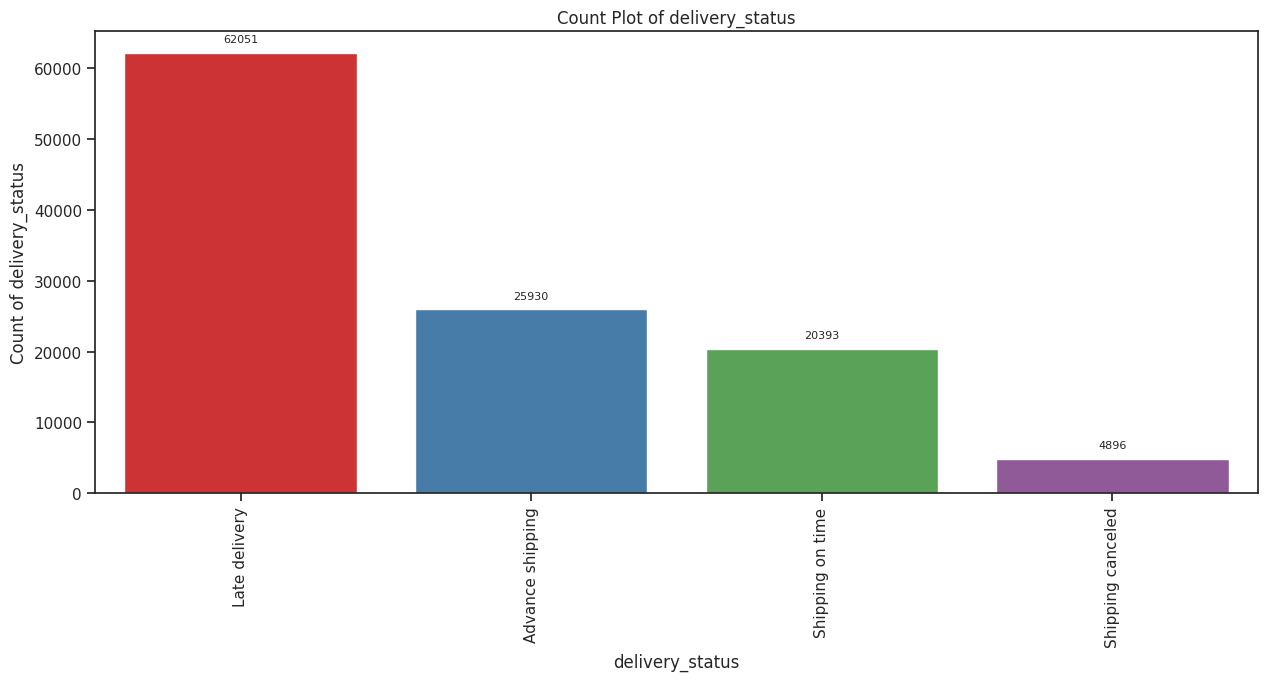

In [ ]:
# Plot count plot of delivery_status
plot_countplot(ecommerce_df, 'delivery_status', fsize=(15,6))

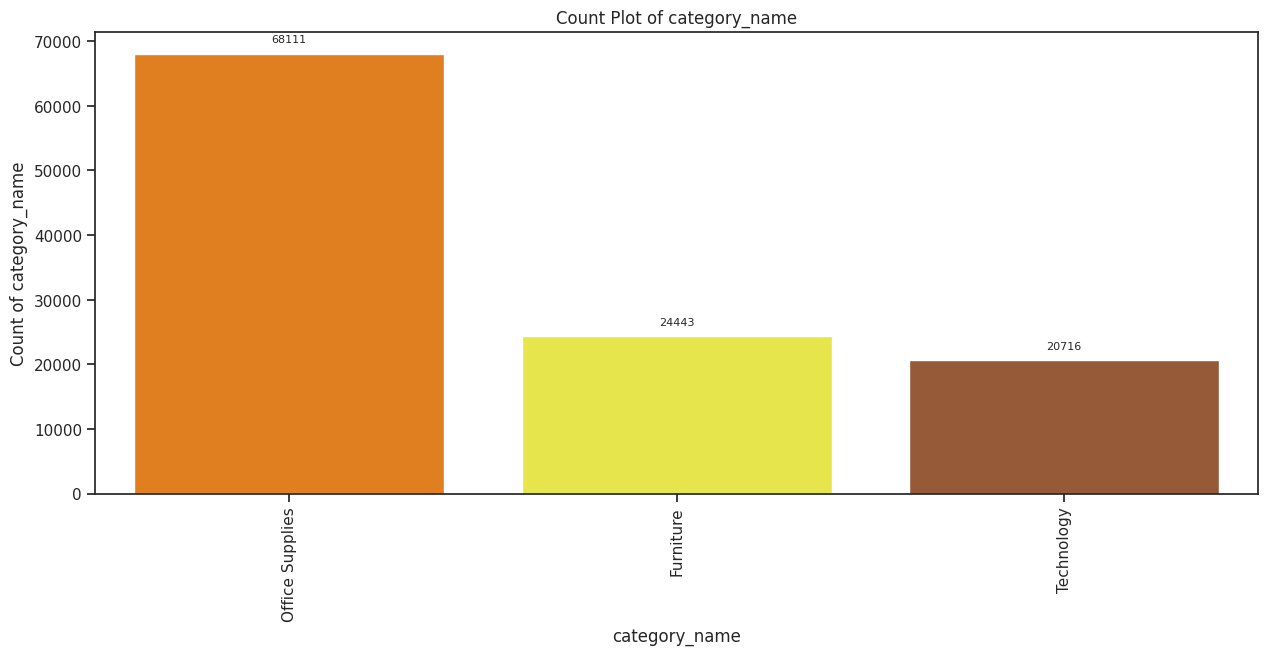

In [ ]:
# Plot count plot of category_name
plot_countplot(ecommerce_df, 'category_name', fsize=(15,6))

#### **Insights from Category Name Count Plot**

- 'Office Supplies' is the most popular category by a significant margin, indicating a high volume of orders in this area.
- 'Furniture' and 'Technology' are the next most popular categories, but with considerably fewer orders compared to Office Supplies.
- The remaining categories have much lower order volumes, suggesting they are less popular or have fewer products.

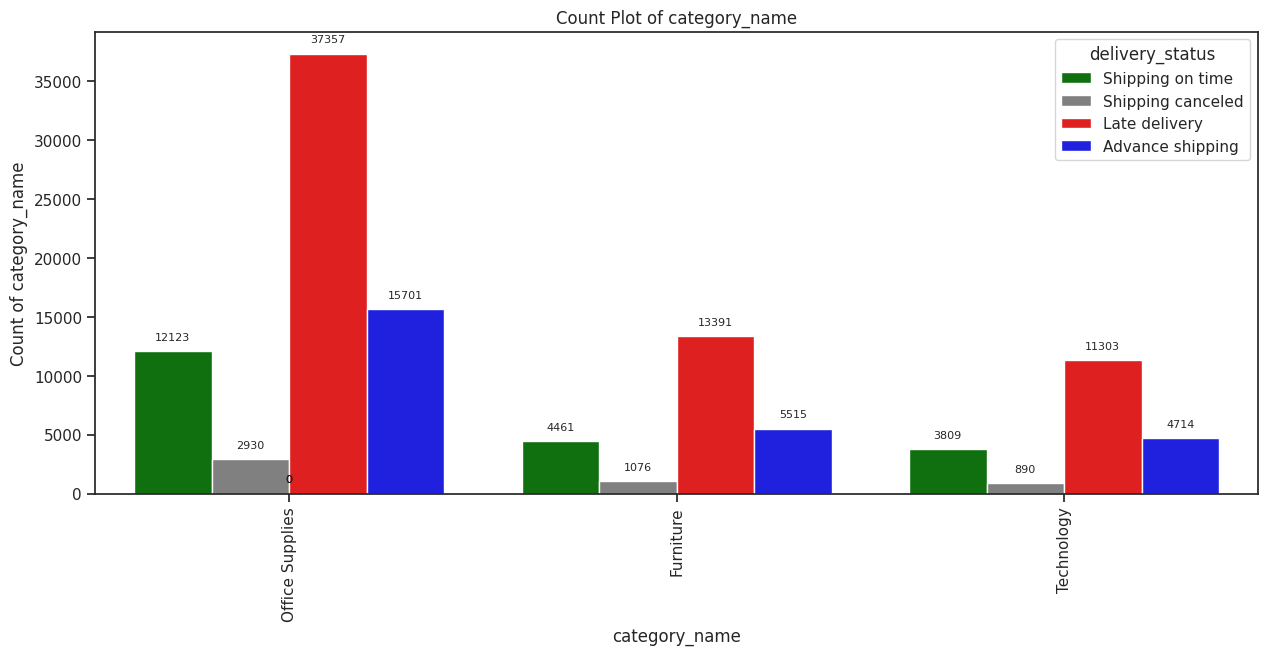

In [ ]:
# Plot count plot of category_name with delivery status as hue
plot_countplot(ecommerce_df, 'category_name', hue='delivery_status', fsize=(15,6))

#### **Insights from Category Name and Delivery Status Count Plot**

- 'Late delivery' is the most frequent delivery status in all categories, reinforcing the earlier observation about late shipments being a major issue.
- Given that 'Office Supplies' has the highest overall order volume, it also has the highest absolute number of late deliveries. This suggests that while it's the most popular category, it's also contributing the most to the late delivery problem in terms of sheer volume.
- While 'Late delivery' is dominant, the proportion of late deliveries compared to other delivery statuses might vary across categories. For instance, are 'Furniture' or 'Technology' orders proportionally more likely to be late than 'Office Supplies' orders? This plot allows for a visual comparison of these proportions.
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by category. Some categories might have a higher proportion of on-time or advance shipments than others.

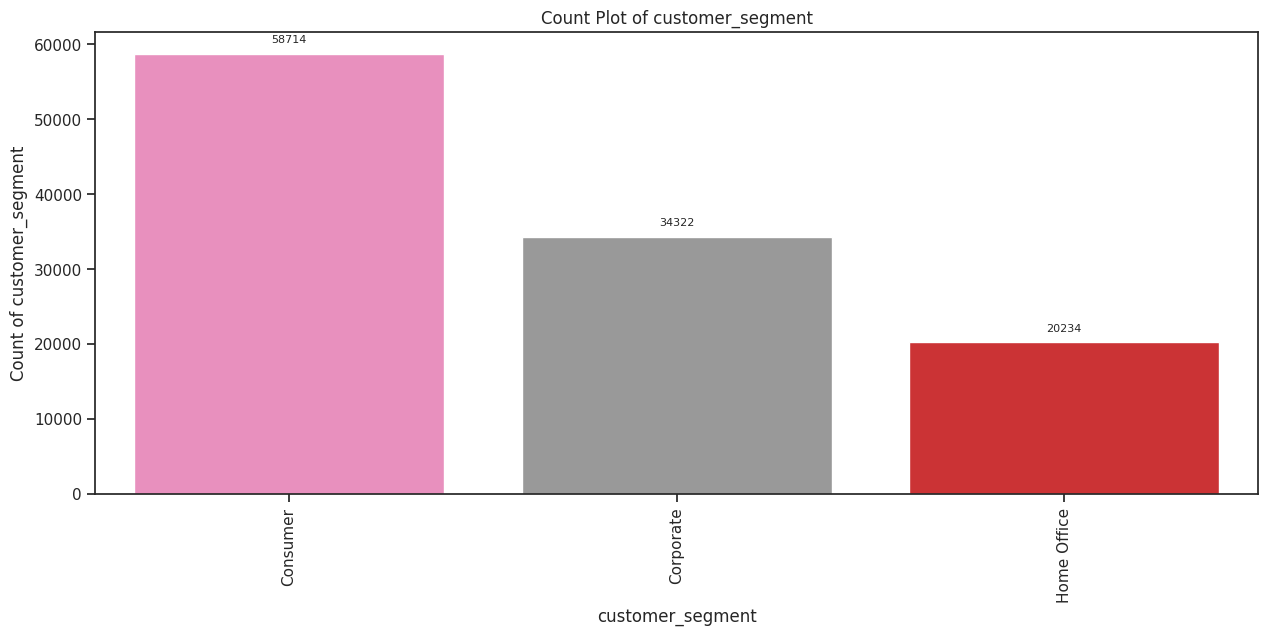

In [ ]:
# Plot count plot of customer_segment
plot_countplot(ecommerce_df, 'customer_segment', fsize=(15,6))

#### **Insights from Customer Segment Count Plot**

- The 'Consumer' segment accounts for the largest number of orders, indicating that individual consumers are the primary customer base.
- 'Corporate' and 'Home Office' segments have fewer orders compared to the 'Consumer' segment.

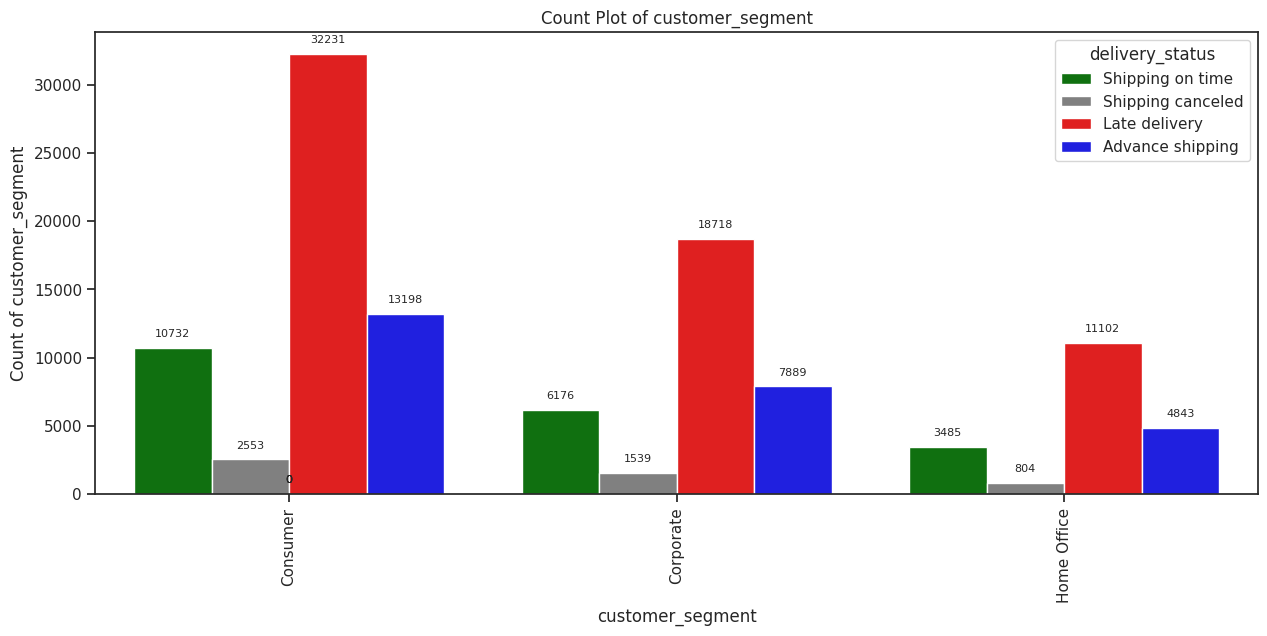

In [ ]:
# Plot count plot of customer_segment with delivery_status as hue
plot_countplot(ecommerce_df, 'customer_segment', hue='delivery_status', fsize=(15,6))

#### **Insights from Customer Segment and Delivery Status Count Plot**

- Similar to the category analysis, 'Late delivery' is the most frequent delivery status across all customer segments. This confirms that late shipments are a pervasive issue, affecting all customer types.
- The 'Consumer' segment, being the largest, also has the highest absolute number of late deliveries.
- While 'Late delivery' is dominant, the proportion of late deliveries compared to other delivery statuses might differ between segments. For example, are 'Corporate' or 'Home Office' customers proportionally more likely to experience late deliveries than 'Consumer' customers?
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by segment, indicating potential differences in shipping preferences or service levels offered to different customer groups.

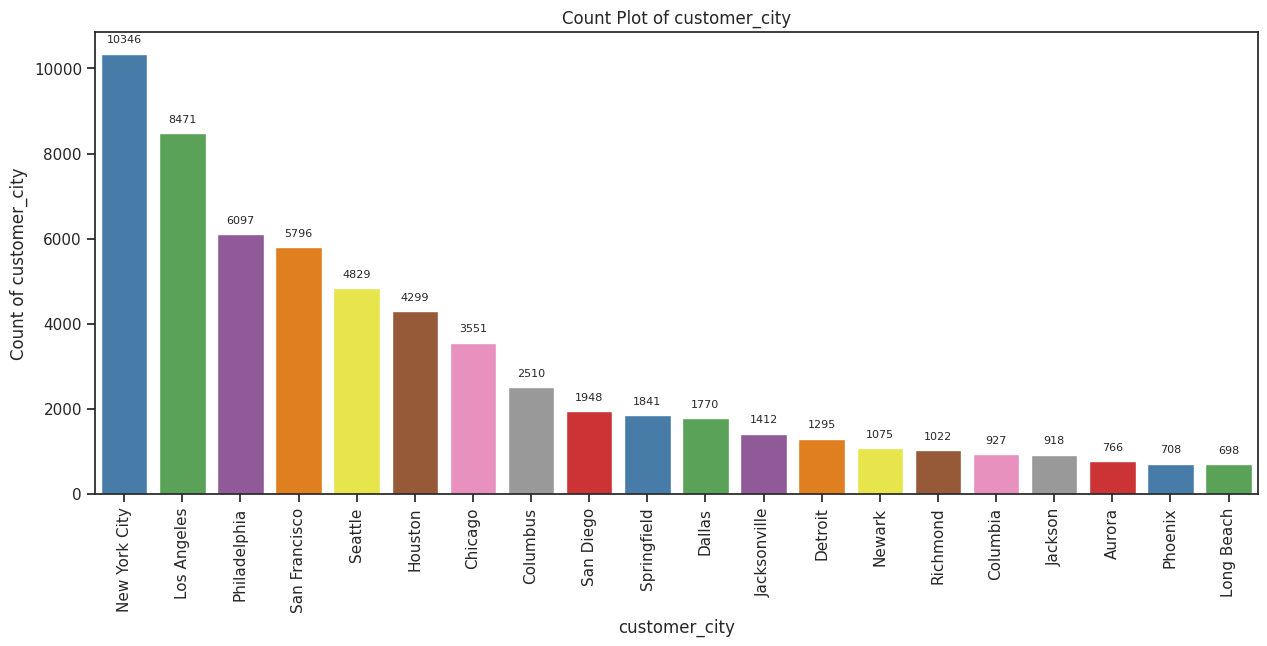

In [ ]:
# Plot count plot of for top 20 customer_city
top_20_cities = ecommerce_df['customer_city'].value_counts().nlargest(20).index.tolist()
ecommerce_top20_cities_df = ecommerce_df[ecommerce_df['customer_city'].isin(top_20_cities)]
plot_countplot(ecommerce_top20_cities_df, 'customer_city', fsize=(15,6))

#### **Insights from Top 20 Customer Cities Count Plot**

- The plot highlights that a significant portion of orders originate from a limited number of cities. This indicates a geographical concentration of the customer base.
- There is considerable variation in order volume among the top 20 cities, with some cities having substantially more orders than others.
- Identifying these high-volume cities is crucial for targeted marketing campaigns, optimizing logistics and shipping routes, and potentially establishing local presence or partnerships.

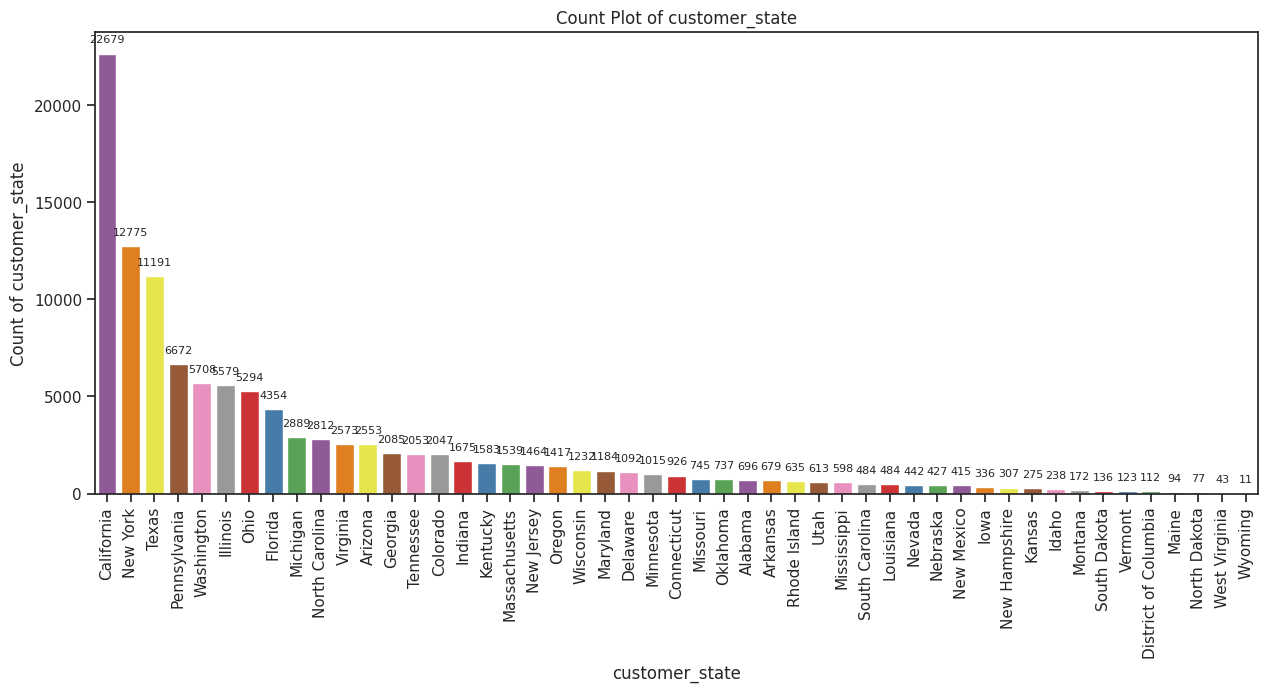

In [ ]:
# Plot countplot for customer_state
plot_countplot(ecommerce_df, 'customer_state', fsize=(15,6))

#### **Insights from Customer State Count Plot**

- The plot reveals the variation in order volume across states, with some states contributing significantly more orders than others. This indicates key states where the business has a strong presence.
- Identifying the states with the highest order volumes is essential for understanding regional market strength, optimizing state-level logistics and distribution, and potentially tailoring marketing efforts to specific states.
- The plot shows a wide range in order numbers per state, highlighting the uneven distribution of the customer base across the country.

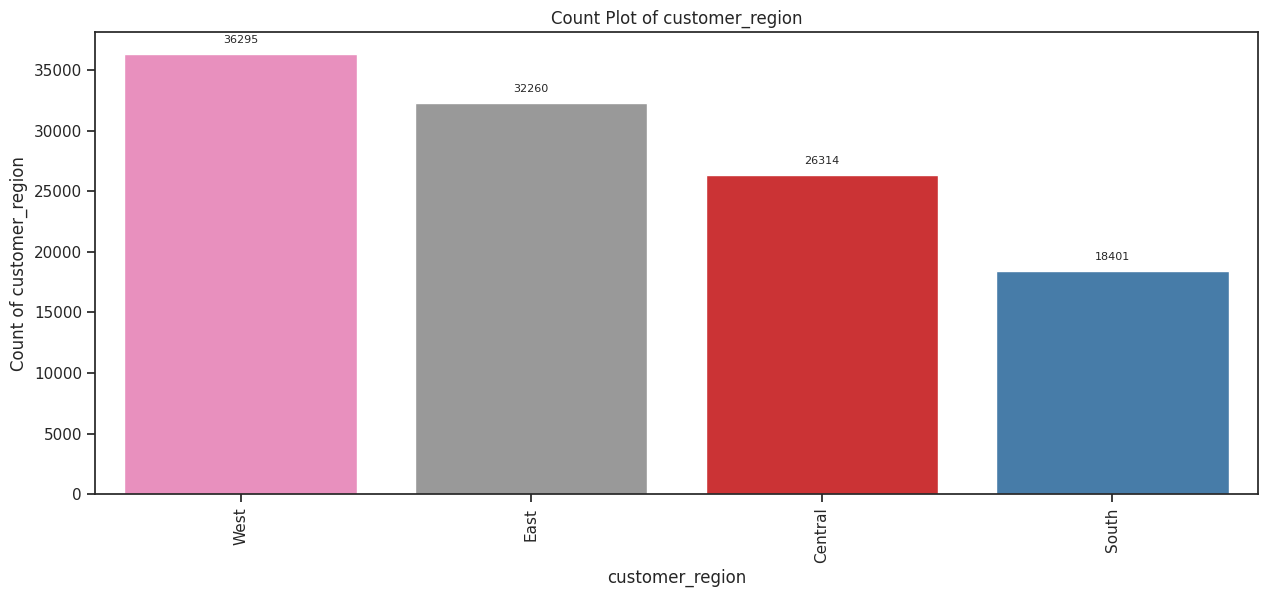

In [ ]:
# Plot count plot for customer_region
plot_countplot(ecommerce_df, 'customer_region', fsize=(15,6))

#### **Insights from Customer Region Count Plot**

- The plot highlights the variation in order volume across the different regions. Some regions have a higher concentration of orders than others.
- Identifying the regions with the highest order volumes is important for understanding key markets and allocating resources effectively for marketing, sales, and logistics.
- The plot allows for a visual comparison of the relative contribution of each region to the total order volume.

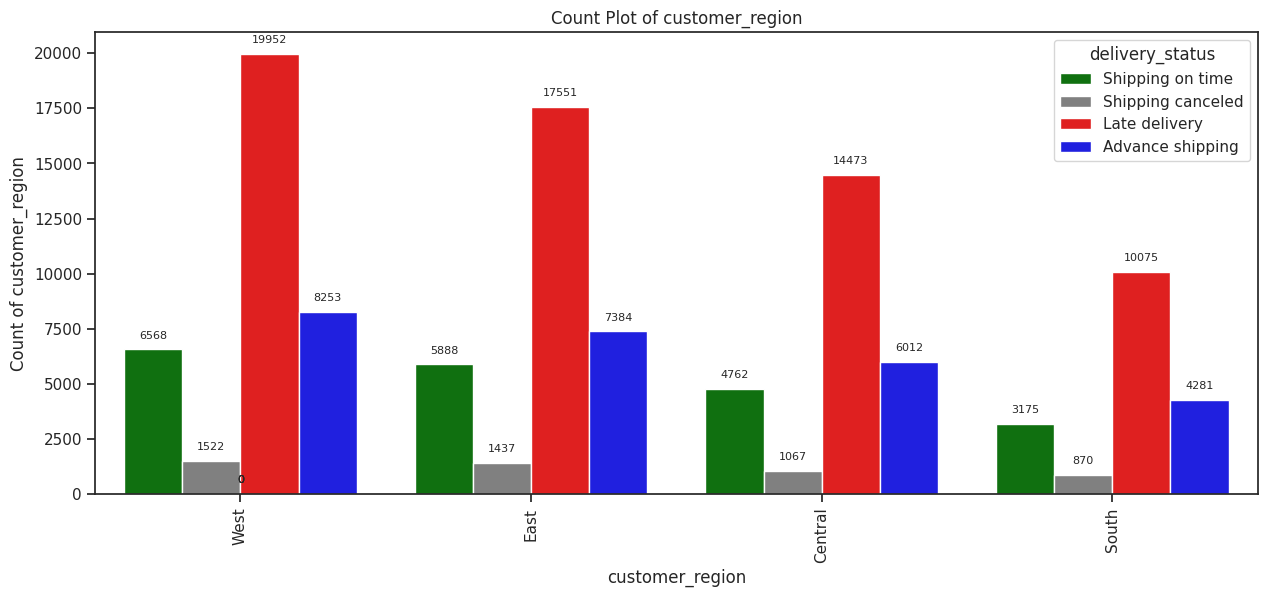

In [ ]:
# Plot count plot for customer_region with delivery_status as hue
plot_countplot(ecommerce_df, 'customer_region', hue='delivery_status', fsize=(15,6))

#### **Insights from Customer Region and Delivery Status Count Plot**

- Consistent with previous analyses, 'Late delivery' is the most prevalent delivery status across all regions. This reinforces that late shipments are a widespread issue, not confined to a specific geographical area.
- While late deliveries are dominant everywhere, there might be subtle differences in the proportion of late deliveries across regions. For instance, some regions might have a slightly higher or lower percentage of late shipments compared to others.
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by region. This could be influenced by factors such as regional logistics infrastructure, distance from distribution centers, or regional customer expectations.
- Identifying regions with a disproportionately high rate of late deliveries (relative to their total order volume) could help prioritize efforts to improve shipping efficiency in those specific areas.

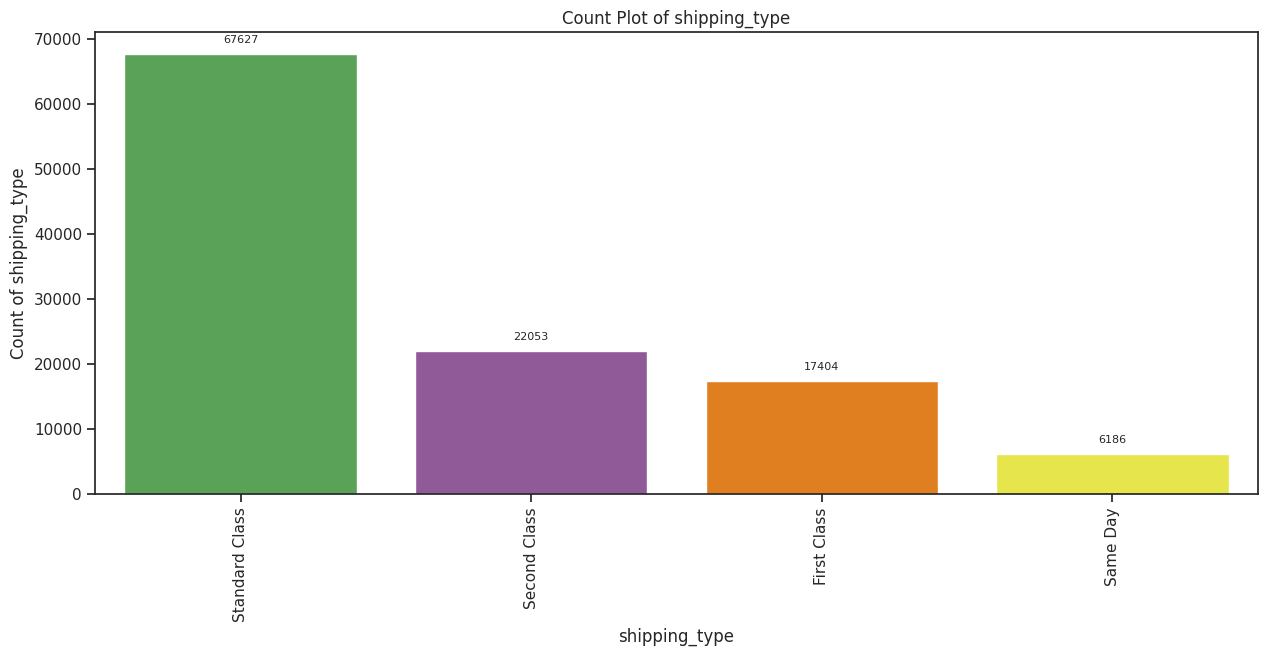

In [ ]:
# Plot count plot for shipping_type
plot_countplot(ecommerce_df, 'shipping_type', fsize=(15,6))

#### **Insights from Shipping Type Count Plot**

- 'Standard Class' is the most frequently used shipping type by a significant margin. This suggests that a large portion of customers choose this option, likely due to a balance of cost and delivery time.
- 'Second Class' and 'First Class' are the next most common shipping types, with decreasing order volumes.
- 'Same Day' shipping has the lowest order volume, which is expected as it is typically the most expensive option and used for urgent deliveries.

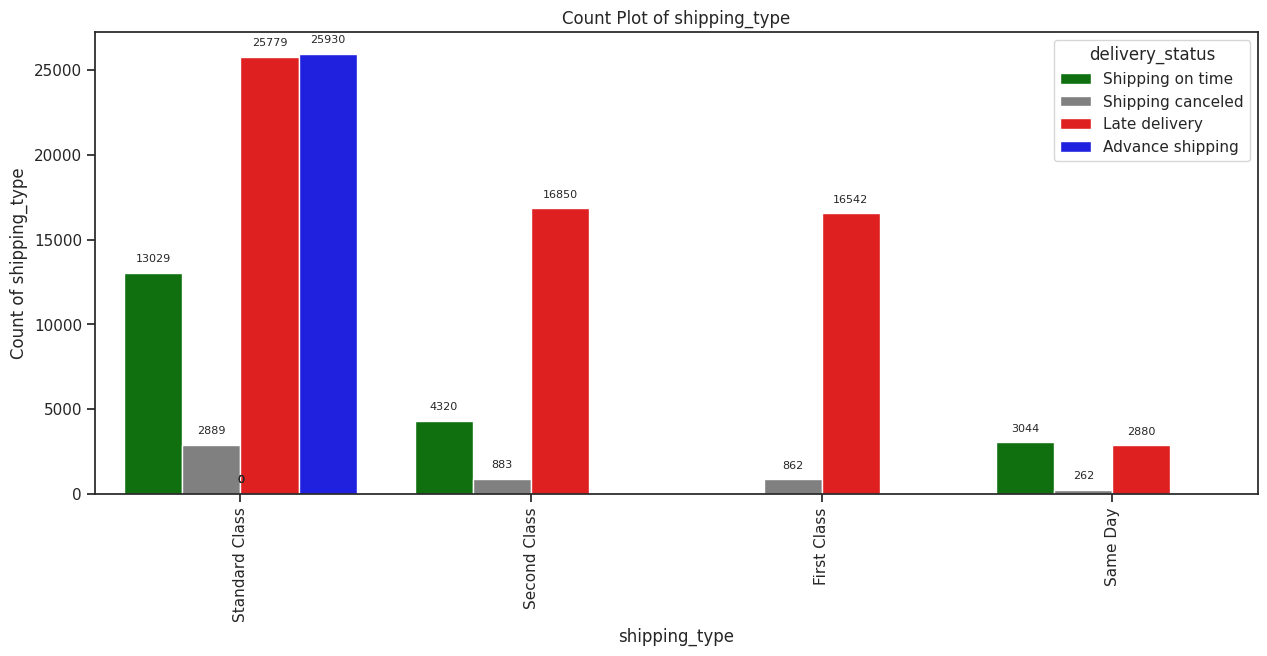

In [ ]:
# Plot count plot for shipping_type with delivery_status as hue
plot_countplot(ecommerce_df, 'shipping_type', hue='delivery_status', fsize=(15,6))

#### **Insights from Shipping Type and Delivery Status Count Plot**

- 'Late delivery' is the most frequent delivery status for all shipping types, reinforcing the overall issue of late shipments.
- Given the high volume of 'Standard Class' shipments, this category also contributes the highest absolute number of late deliveries.
- It's important to look at the *proportion* of late deliveries within each shipping type. For example, is 'Same Day' shipping proportionally more likely to be late than 'Standard Class'? This plot allows for visual comparison of these proportions.
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by shipping type, which could be related to the inherent speed and service level associated with each type.

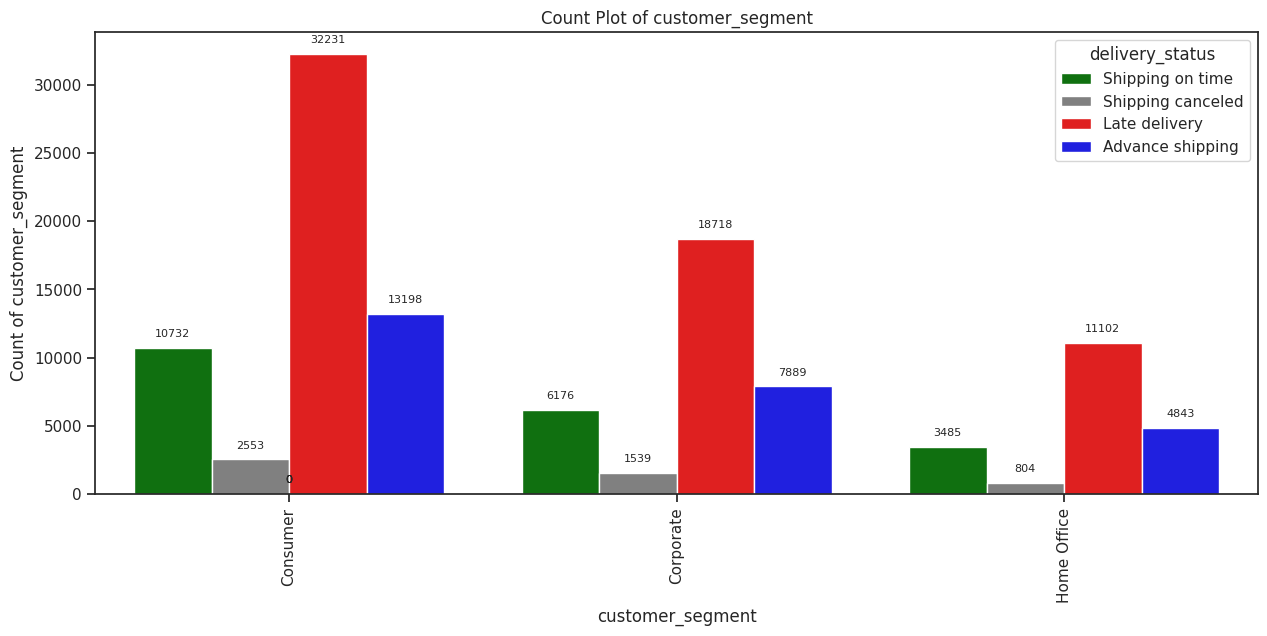

In [ ]:
# Plot count plot for customer_segment with delivery_status as hue
plot_countplot(ecommerce_df, 'customer_segment', hue='delivery_status',fsize=(15,6))

#### **Insights from Customer Segment and Delivery Status Count Plot**

- Similar to the category analysis, 'Late delivery' is the most frequent delivery status across all customer segments. This confirms that late shipments are a pervasive issue, not confined to a specific geographical area.
- The 'Consumer' segment, being the largest, also has the highest absolute number of late deliveries.
- While 'Late delivery' is dominant, the proportion of late deliveries compared to other delivery statuses might differ between segments. For example, are 'Corporate' or 'Home Office' customers proportionally more likely to experience late deliveries than 'Consumer' customers?
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by segment, indicating potential differences in shipping preferences or service levels offered to different customer groups.

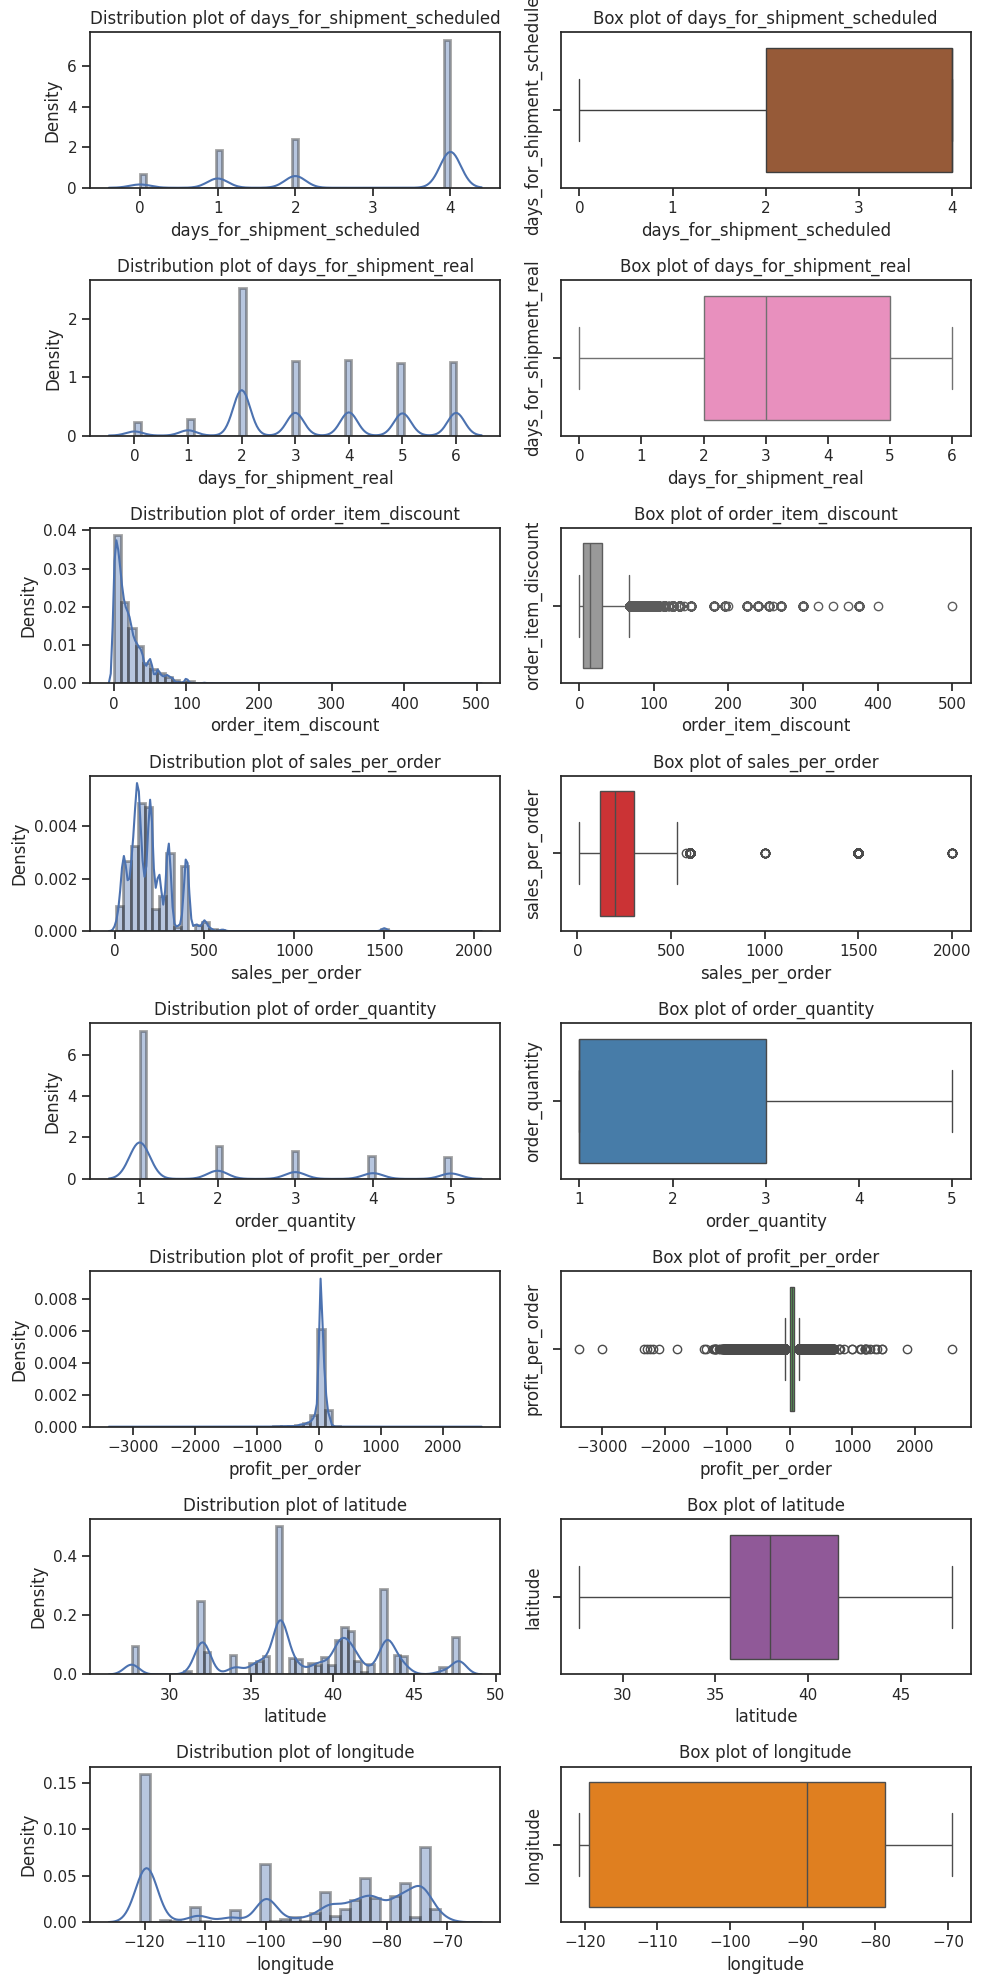

In [ ]:
# Distribution and boxplots of the numeric variables

a = len(numeric_cols)  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig1 = plt.figure(figsize=(10,20))

for i in numeric_cols:
    plt.subplot(a, b, c)
    plt.title('Distribution plot of {}'.format(i))
    plt.xlabel(i)
    sns.distplot(ecommerce_df[i], hist_kws=dict(edgecolor="k", linewidth=2))
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('Box plot of {}'.format(i))
    plt.ylabel(i)
    sns.boxplot(x = ecommerce_df[i], orient='h', palette=palette1)
    c = c + 1

plt.tight_layout()
plt.show()


#### **Insights from Distribution and Box Plots of Numeric Variables**

- The distributions show the spread of planned and actual shipment times. The box plots highlight the median values and the presence of potential outliers in both scheduled and real shipment days. The difference between the two (analyzed in a later plot) is crucial for understanding delivery performance.
- The distribution appears skewed, with a concentration of lower discount values and a long tail extending to higher discounts. The box plot confirms the presence of outliers with very high discount percentages.
- Similar to discount, sales per order also shows a skewed distribution with many orders having lower sales values and fewer orders with significantly higher sales. The box plot reveals numerous outliers on the higher end, indicating some very large orders.
- The distribution is heavily skewed towards lower order quantities (likely 1 or 2 items per order). The box plot clearly shows outliers representing orders with a much larger number of items.
- This variable exhibits a wide distribution with both positive and negative values, indicating that some orders result in losses. The box plot reveals significant outliers on both the positive and negative sides, highlighting highly profitable and highly unprofitable orders.
- These plots show the geographical distribution of customer locations. The box plots provide a sense of the central tendency and spread of customer locations based on latitude and longitude.

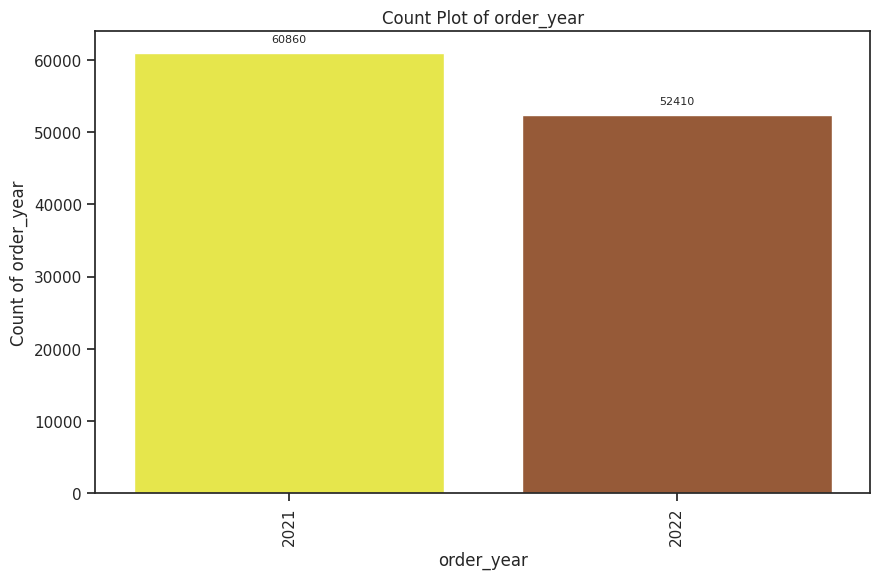

In [ ]:
# Number of orders per year
ecommerce_df['order_year'] = ecommerce_df['order_date'].dt.year

plot_countplot(ecommerce_df, 'order_year', fsize=(10,6))

#### Insights from Order Year Count Plot

- The plot clearly shows the total number of orders for each year present in the dataset.
- This allows for a direct comparison of order volume between the years. We can observe if there's an increasing, decreasing, or relatively stable trend in the number of orders year over year.

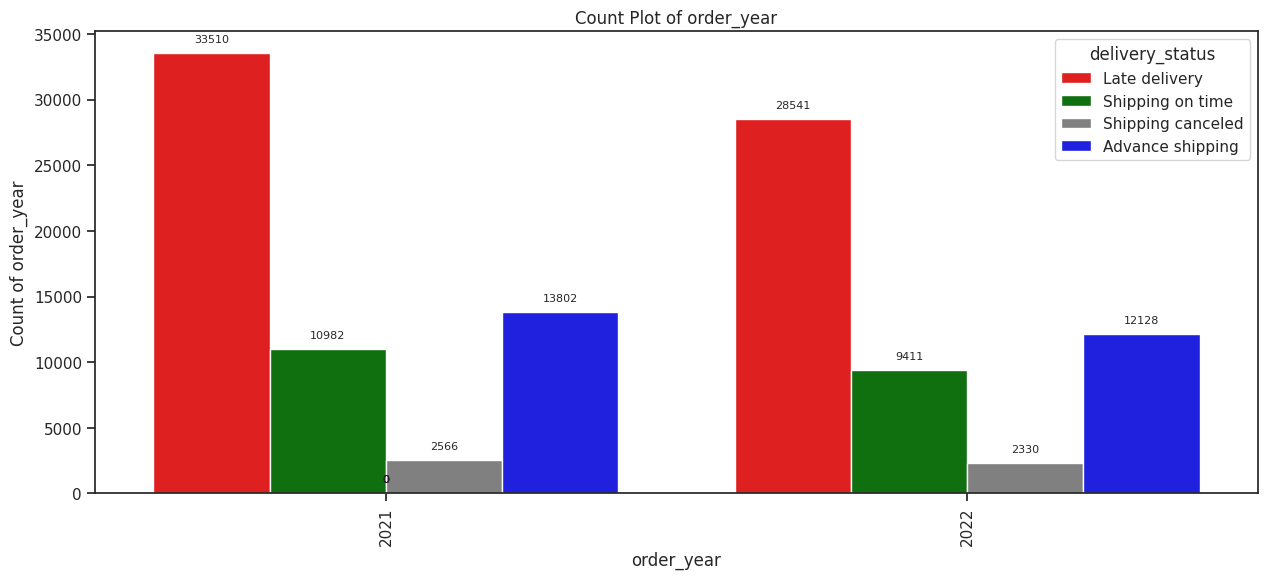

In [ ]:
# Plot count plot of order_year with delivery_status as hue
plot_countplot(ecommerce_df, 'order_year', hue='delivery_status', fsize=(15,6))

#### **Insights from Order Year and Delivery Status Count Plot**

- 'Late delivery' is the most frequent delivery status in both years, indicating that the issue of late shipments persisted across this period.
- The plot allows for a visual comparison of the distribution of all delivery statuses between the two years. Are late deliveries proportionally more or less common in one year compared to the other?
- While 2022 has a lower overall order volume, it's important to see how the absolute numbers of each delivery status compare to 2021.

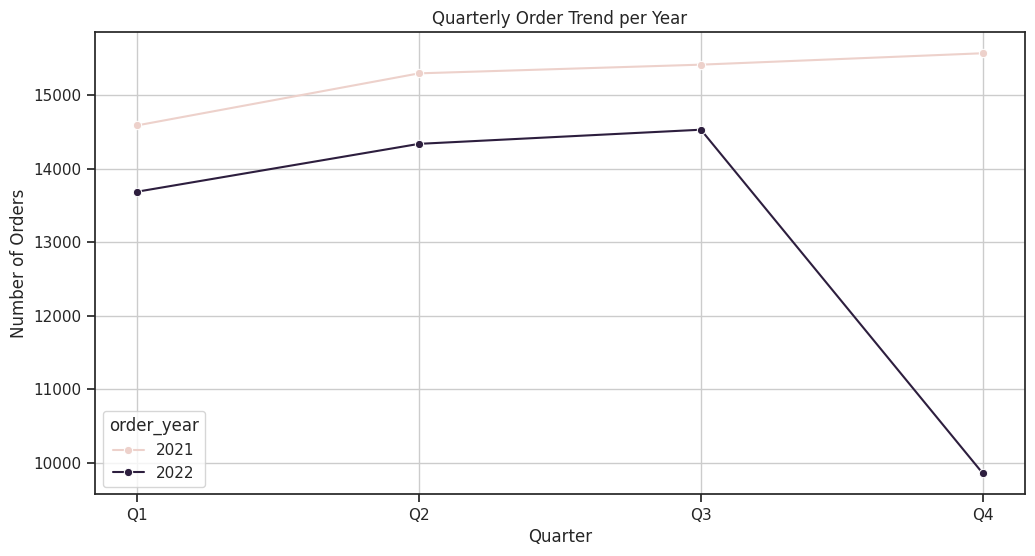

In [ ]:
# Calculate quarterly orders per year
ecommerce_df['order_quarter'] = ecommerce_df['order_date'].dt.quarter
quarterly_orders = ecommerce_df.groupby(['order_year', 'order_quarter']).size().reset_index(name='order_count')

# Plot quarterly orders per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarterly_orders, x='order_quarter', y='order_count', hue='order_year', marker='o')
plt.title('Quarterly Order Trend per Year')
plt.xlabel('Quarter')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 5), ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True)
plt.show()

#### **Insights from Quarterly Order Trend per Year**

- The plot clearly illustrates how order volume changes from quarter to quarter within each year. There are noticeable peaks and dips, suggesting seasonal variations in customer purchasing behavior.
- The lines for each year allow for a direct comparison of order volumes in the same quarter across different years. This helps to identify if certain quarters are consistently higher or lower in order volume and if there are any significant year-over-year changes in quarterly performance.
- Consistent patterns across both years (e.g., a peak in Q4) would indicate strong seasonality that could be leveraged for planning and forecasting.
- The plot provides a visual representation of the overall trend in order volume across the quarters and years in the dataset.

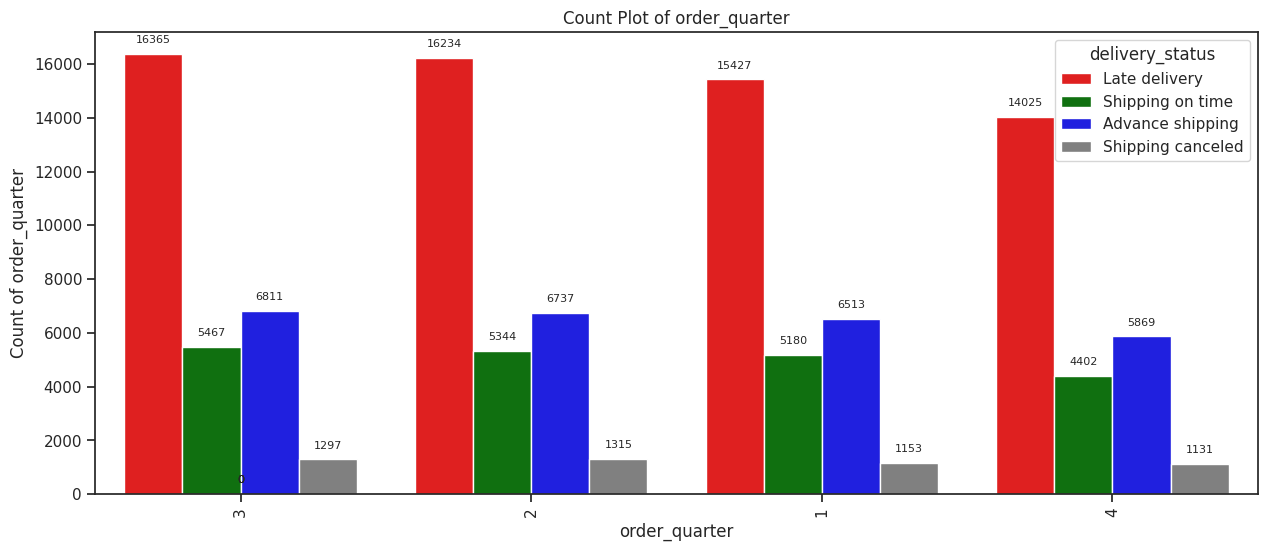

In [ ]:
# Plot count plot of order_quarter with delivery_status as hue
plot_countplot(ecommerce_df, 'order_quarter', hue='delivery_status', fsize=(15,6))

#### **Insights from Order Quarter and Delivery Status Count Plot**

- 'Late delivery' remains the most frequent delivery status in all quarters, indicating that late shipments are a consistent issue throughout the year.
- While 'Late delivery' is dominant, the *proportion* of late deliveries relative to other statuses might vary across quarters. For example, is there a quarter with a notably higher or lower percentage of on-time or advance shipments?
- This plot can reveal if certain quarters, perhaps those with higher order volumes (as seen in the quarterly trend plot), experience a greater strain on the delivery system, potentially leading to a higher proportion of late deliveries.
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by quarter, which could be influenced by seasonal factors or operational adjustments made throughout the year.

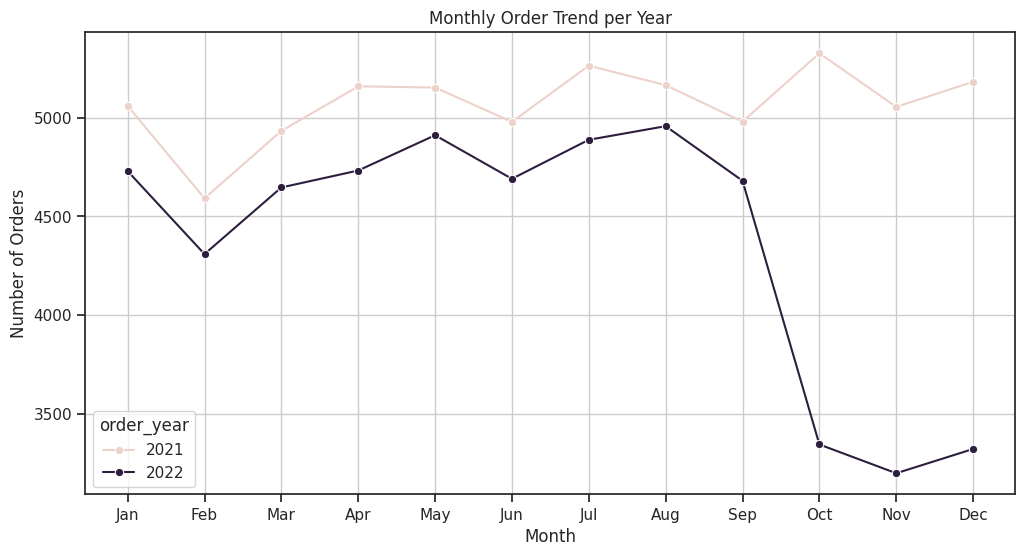

In [ ]:
# Extract month and year
ecommerce_df['order_month'] = ecommerce_df['order_date'].dt.month

# Calculate monthly orders per year
monthly_orders = ecommerce_df.groupby(['order_year', 'order_month']).size().reset_index(name='order_count')

# Plot monthly orders per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_orders, x='order_month', y='order_count', hue='order_year', marker='o')
plt.title('Monthly Order Trend per Year')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

#### **Insights from Monthly Order Trend per Year**

- The plot clearly illustrates how order volume changes from month to month within each year. This allows for the identification of specific peak and trough months.
- The lines for each year enable a direct comparison of order volumes for the same month across different years. This helps to identify if certain months consistently have higher or lower order volumes and if there are any significant year-over-year changes in monthly performance.
- Consistent patterns across both years (e.g., a dip in a specific summer month or a peak in a holiday month) would indicate strong seasonality that can be used for more precise planning, inventory management, and marketing campaigns.
- The plot provides a detailed visual representation of the overall trend in order volume throughout the months and years in the dataset.

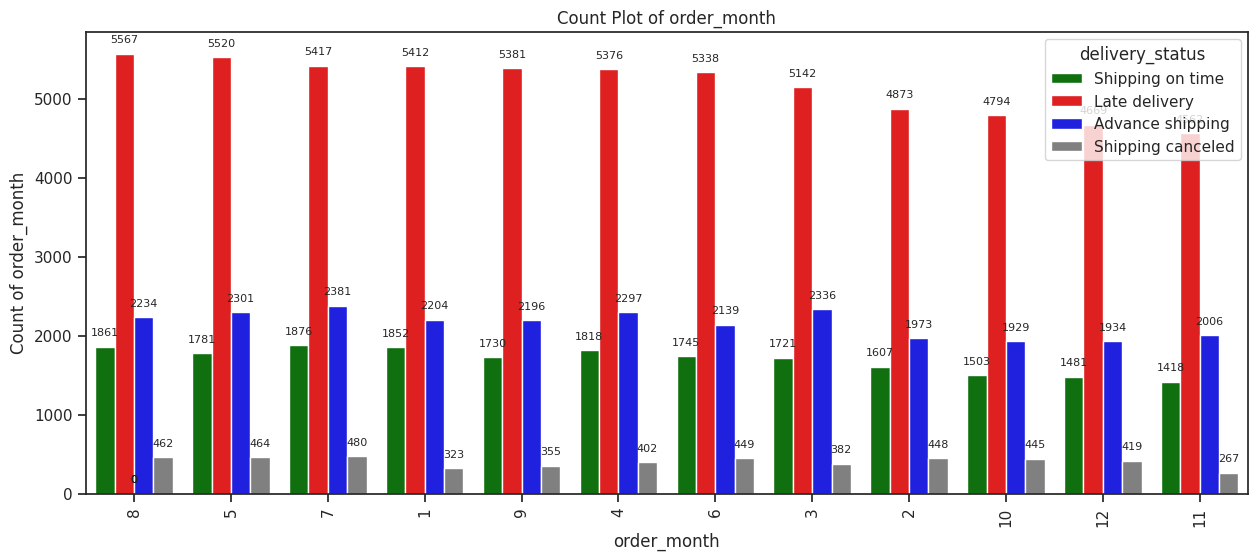

In [ ]:
# Plot count plot of order_month with delivery_status as hue
plot_countplot(ecommerce_df, 'order_month', hue='delivery_status', fsize=(15,6))

#### **Insights from Order Month and Delivery Status Count Plot**

- 'Late delivery' is the most frequent delivery status in all months, consistent with the overall trend.
- While 'Late delivery' is dominant, the *proportion* of late deliveries relative to other statuses might vary from month to month. This can help identify if certain months are particularly challenging for on-time deliveries.
- This plot can reveal if seasonal peaks in order volume (observed in the monthly trend plot) correlate with a higher proportion of late deliveries, suggesting a strain on logistics during busy periods.
- The distribution of 'Advance shipping' and 'Shipping on time' also varies by month, potentially reflecting seasonal operational changes or customer behavior.

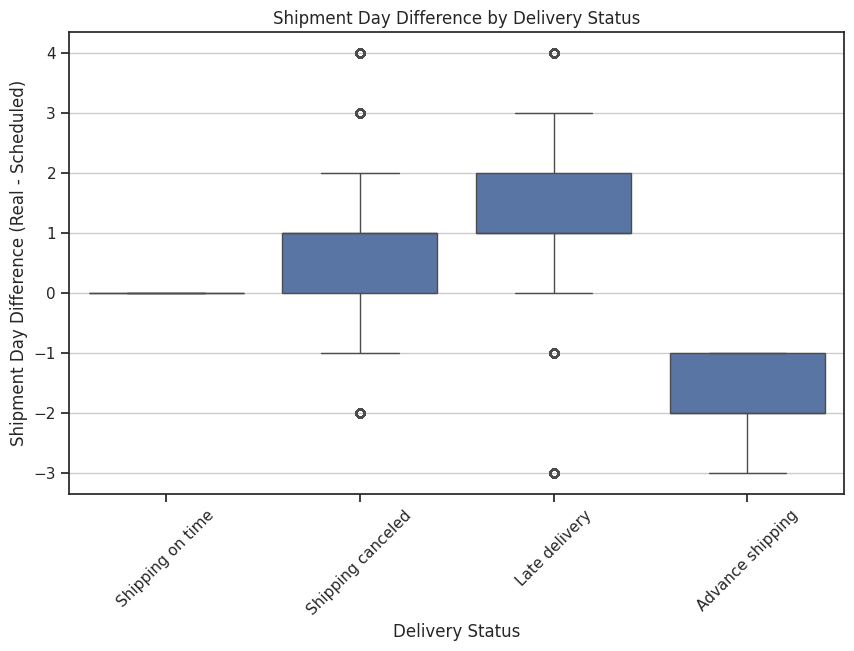

In [ ]:
# Calculate the difference between real and scheduled shipment days
ecommerce_df['shipment_day_difference'] = ecommerce_df['days_for_shipment_real'] - ecommerce_df['days_for_shipment_scheduled']

# Visualize the distribution of shipment day difference for each delivery status
plt.figure(figsize=(10, 6))
sns.boxplot(x='delivery_status', y='shipment_day_difference', data=ecommerce_df)
plt.title('Shipment Day Difference by Delivery Status')
plt.xlabel('Delivery Status')
plt.ylabel('Shipment Day Difference (Real - Scheduled)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### **Insights from Shipment Day Difference by Delivery Status Box Plot**

- As expected, 'Late delivery' has a positive median `shipment_day_difference`, indicating that real shipment days were generally higher than scheduled days for these orders. The box plot shows a wide spread of positive values, with many outliers, confirming that late deliveries can range from slightly delayed to significantly delayed.
- 'Shipping on time' has a median `shipment_day_difference` around zero, which is the ideal scenario where real shipment days match scheduled days. The box is relatively tight around zero, suggesting consistency in meeting scheduled times for these orders. There might be some minor variations, but the majority are close to zero difference.
- 'Advance shipping' shows a negative median `shipment_day_difference`, meaning real shipment days were generally lower than scheduled days. The box plot indicates that these orders were shipped earlier than planned, with a range of negative differences.
- 'Shipping canceled' also shows a distribution of `shipment_day_difference`. The interpretation here might be less straightforward in terms of delivery time performance, as the shipment was canceled. However, the plot can still show if there were delays or early shipments *before* the cancellation occurred.

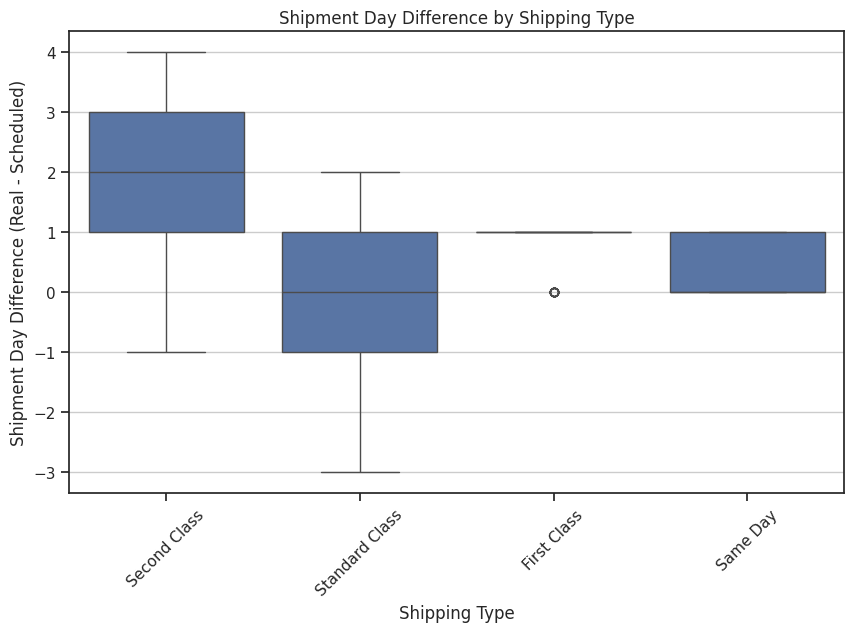

In [ ]:
# Visualize shipment day difference by shipping type
plt.figure(figsize=(10, 6))
sns.boxplot(x='shipping_type', y='shipment_day_difference', data=ecommerce_df)
plt.title('Shipment Day Difference by Shipping Type')
plt.xlabel('Shipping Type')
plt.ylabel('Shipment Day Difference (Real - Scheduled)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### **Insights from Shipment Day Difference by Shipping Type Box Plot**

- The box plots for each shipping type (Standard Class, Second Class, First Class, Same Day) show the distribution of shipment day differences.
- The median line within each box indicates the typical difference between real and scheduled shipment days for that shipping type. A median close to zero suggests that the shipping type generally meets its scheduled delivery time. A positive median indicates typical delays, while a negative median suggests shipments are usually early.
- The size of the box and the length of the whiskers show the variability in shipment times for each shipping type. Outliers represent unusually early or delayed shipments for that method.
- By comparing the box plots, we can see which shipping types are more reliable (less variability, median closer to zero) and which are more prone to delays or early shipments. For example, is 'Same Day' shipping consistently on time, or does it have a wider spread of differences?

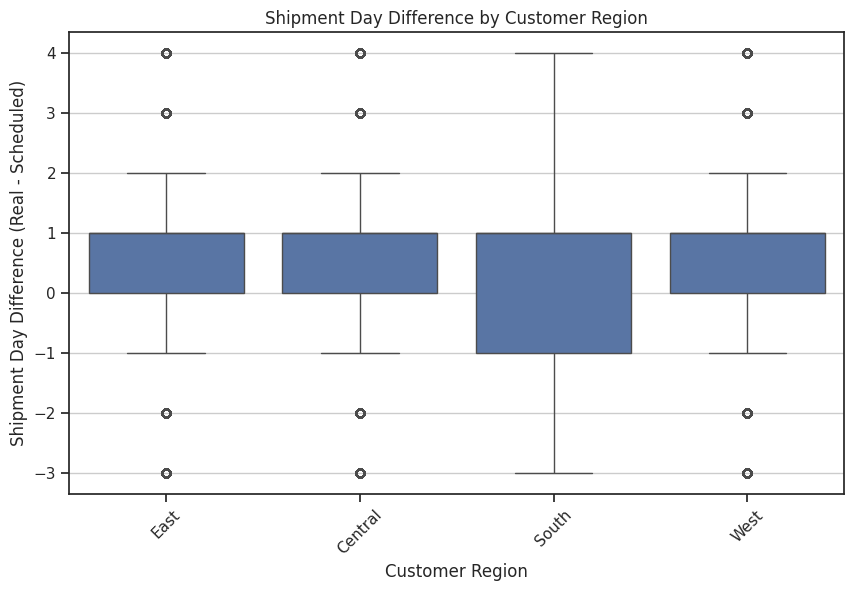

In [ ]:
# Visualize shipment day difference by customer region
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer_region', y='shipment_day_difference', data=ecommerce_df)
plt.title('Shipment Day Difference by Customer Region')
plt.xlabel('Customer Region')
plt.ylabel('Shipment Day Difference (Real - Scheduled)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### **Insights from Shipment Day Difference by Customer Region Box Plot**

- The box plots for each customer region show the distribution of shipment day differences.
- The median line within each box indicates the typical difference between real and scheduled shipment days for that region. A median close to zero suggests that shipments in that region generally meet their scheduled delivery time. A positive median indicates typical delays, while a negative median suggests shipments are usually early.
- The size of the box and the length of the whiskers show the variability in shipment times for each region. Outliers represent unusually early or delayed shipments for that region.
- By comparing the box plots, we can see which regions are more reliable in terms of meeting scheduled delivery times and which are more prone to delays or early shipments.

In [ ]:
# Statistical summary of the numeric_cols
ecommerce_df_stat = ecommerce_df[numeric_cols].describe().T
ecommerce_df_stat['Skew']=ecommerce_df[numeric_cols].skew(axis=0)
ecommerce_df_stat['Kurtosis']=ecommerce_df[numeric_cols].kurtosis(axis=0)
display(ecommerce_df_stat)

,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis
days_for_shipment_scheduled,113270.0,2.931209,1.375914,0.000000,2.000000,4.000000,4.000000,4.000000,-0.733431,-1.020496
days_for_shipment_real,113270.0,3.464006,1.632198,0.000000,2.000000,3.000000,5.000000,6.000000,0.097180,-1.013137
order_item_discount,113270.0,21.105465,22.959207,0.000000,5.500000,14.400000,30.000000,500.000000,3.540025,31.471262
sales_per_order,113270.0,204.499537,141.443090,9.990000,119.980003,199.919998,299.950012,1999.989990,3.521108,28.307808
order_quantity,113270.0,1.967564,1.355254,1.000000,1.000000,1.000000,3.000000,5.000000,1.114965,-0.176346
profit_per_order,113270.0,23.069382,105.288561,-3366.000000,7.200000,32.029999,65.570000,2600.000000,-3.417022,50.207877
latitude,113270.0,38.513731,4.756761,27.664827,35.759573,37.964253,41.603221,47.751074,-0.179172,-0.394186
longitude,113270.0,-94.771186,17.682753,-120.740139,-119.417932,-89.398528,-78.656894,-69.445469,-0.346411,-1.448031


#### **Inferences from Statistical Summary of Numeric Variables**

- **`days_for_shipment_scheduled`:**
  - **Mean (2.93) vs. Median (4.00):** The median is higher than the mean, and the negative skewness (-0.73) indicates the distribution is slightly skewed to the left. This means there are more instances of shorter scheduled shipment times than longer ones, but the most frequent scheduled time is 4 days.
  - **Std Dev (1.38):** The standard deviation is relatively small, suggesting that scheduled shipment times don't vary widely.
  - **Min (0) and Max (4):** Scheduled shipment times range from 0 to 4 days.
  - **Kurtosis (-1.02):** The negative kurtosis suggests a flatter distribution than a normal distribution.

- **`days_for_shipment_real`:**
  - **Mean (3.46) vs. Median (3.00):** The mean is slightly higher than the median, and the near-zero skewness (0.10) indicates the distribution is close to symmetrical. This suggests that real shipment times are more evenly distributed than scheduled times.
  - **Std Dev (1.63):** The standard deviation is slightly larger than `days_for_shipment_scheduled`, indicating a bit more variability in actual shipment times.
  - **Min (0) and Max (6):** Real shipment times range from 0 to 6 days.
  - **Kurtosis (-1.01):** Similar to scheduled days, the negative kurtosis suggests a flatter distribution.

- **`order_item_discount`:**
  - **Mean (21.11) vs. Median (14.40):** The mean is significantly higher than the median, and the high positive skewness (3.54) indicates a strong rightward skew. This confirms that most orders have lower discounts, with a long tail of orders receiving much higher discounts.
  - **Std Dev (22.96):** The standard deviation is large relative to the mean, reflecting the wide range of discount values.
  - **Min (0) and Max (500):** Discounts range from 0% to a very high 500% (which might warrant further investigation for data anomalies).
  - **Kurtosis (31.47):** The very high kurtosis indicates a highly peaked distribution with heavy tails, confirming the presence of significant outliers on the higher end.

- **`sales_per_order`:**
  - **Mean (204.50) vs. Median (199.92):** The mean is slightly higher than the median, and the high positive skewness (3.52) indicates a strong rightward skew. This shows that most orders have lower sales values, with a long tail of orders generating much higher sales.
  - **Std Dev (141.44):** The standard deviation is large, reflecting the wide variability in sales per order.
  - **Min (9.99) and Max (1999.99):** Sales per order range from approximately $10 to $2000.
  - **Kurtosis (28.31):** The very high kurtosis indicates a highly peaked distribution with heavy tails, confirming the presence of significant outliers on the higher end.

- **`order_quantity`:**
  - **Mean (1.97) vs. Median (1.00):** The mean is higher than the median, and the positive skewness (1.11) indicates a rightward skew. This confirms that most orders are for a small quantity of items (most frequently 1), with fewer orders for larger quantities.
  - **Std Dev (1.36):** The standard deviation is relatively small, reflecting that most orders are for low quantities.
  - **Min (1) and Max (5):** Order quantities range from 1 to 5 items.
  - **Kurtosis (-0.18):** The kurtosis is close to zero, suggesting a distribution similar in peakedness to a normal distribution.

- **`profit_per_order`:**
  - **Mean (23.07) vs. Median (32.03):** The mean is lower than the median, and the high negative skewness (-3.42) indicates a strong leftward skew. This shows that while the median profit is positive, there's a significant number of orders with lower or even negative profits, pulling the mean down.
  - **Std Dev (105.29):** The standard deviation is very large relative to the mean, indicating a wide spread of profit values, including significant losses and high profits.
  - **Min (-3366.00) and Max (2600.00):** Profit per order ranges from a loss of $3366 to a profit of $2600.
  - **Kurtosis (50.21):** The very high kurtosis indicates a highly peaked distribution with heavy tails on both the positive and negative sides, confirming the presence of significant outliers representing both large profits and large losses.

- **`latitude` and `longitude`:**
  - **Mean and Median:** The mean and median values provide the approximate center of the geographical distribution of customers.
  - **Std Dev:** The standard deviations indicate the spread of customer locations in terms of latitude and longitude.
  - **Min and Max:** The minimum and maximum values define the geographical bounding box of the customer base.
  - **Skewness and Kurtosis:** The low absolute values of skewness and kurtosis suggest that the geographical distribution is relatively symmetrical and not highly peaked.

#### **Overall Univariate Analysis Inferences**

**Delivery Status:**
- The majority of orders were **'Late delivery'**, followed by 'Advance shipping', 'Shipping on time', and 'Shipping canceled'. This indicates that late deliveries are a significant issue that needs further investigation.

**Category Name:**
- **'Office Supplies'** is the most frequent category, followed by 'Furniture' and 'Technology'. This suggests that office supplies are the most popular product type among customers.

**Customer Segment:**
- The **'Consumer'** segment accounts for the highest number of orders, followed by 'Corporate' and 'Home Office'. This indicates that individual consumers are the largest customer base.

**Customer City, State, and Region:**
- The count plots for customer city, state, and region show the geographical distribution of orders. Some cities, states, and regions have significantly higher order volumes than others. This information can be useful for targeted marketing and logistics planning.

**Shipping Type:**
- **'Standard Class'** is the most frequently used shipping type, followed by 'Second Class', 'First Class', and 'Same Day'. This suggests that most customers opt for standard shipping.

**Numeric Columns (Sales, Profit, Discount, Quantity, Shipment Days):**
- The distribution plots and box plots for the numeric columns provide insights into their ranges, central tendencies, and potential outliers.
  - **`sales_per_order` and `profit_per_order`** show wide distributions with several outliers, indicating variability in order values and profitability.
  - **`order_item_discount`** also has a range of values, suggesting different discount strategies are in place.
  - **`order_quantity`** primarily shows small quantities, but there are outliers with much larger quantities.
  - **`days_for_shipment_scheduled` and `days_for_shipment_real`** show the planned and actual shipment durations. The box plot of `shipment_day_difference` clearly illustrates the distribution of early, on-time, and late shipments.

**Temporal Analysis (Order Year, Quarter, Month):**
- The analysis of orders over time reveals trends and potential seasonality:
  - **Order Year:** There is a difference in the total number of orders between 2021 and 2022, with 2022 having fewer orders overall, especially in the latter months.
  - **Quarterly and Monthly Trends:** The line plots show the order trends within each year. We can observe fluctuations in order volume across months and quarters. Identifying consistent peaks or dips in specific months or quarters across both years could indicate seasonal patterns. For instance, there might be a dip in orders in certain months or a peak in others due to holidays or other factors.

These univariate analyses provide a foundational understanding of the dataset and highlight areas that warrant further investigation, such as the factors contributing to late deliveries and the reasons for the decline in orders in late 2022.

### 3.2. Bi-Variate Analysis

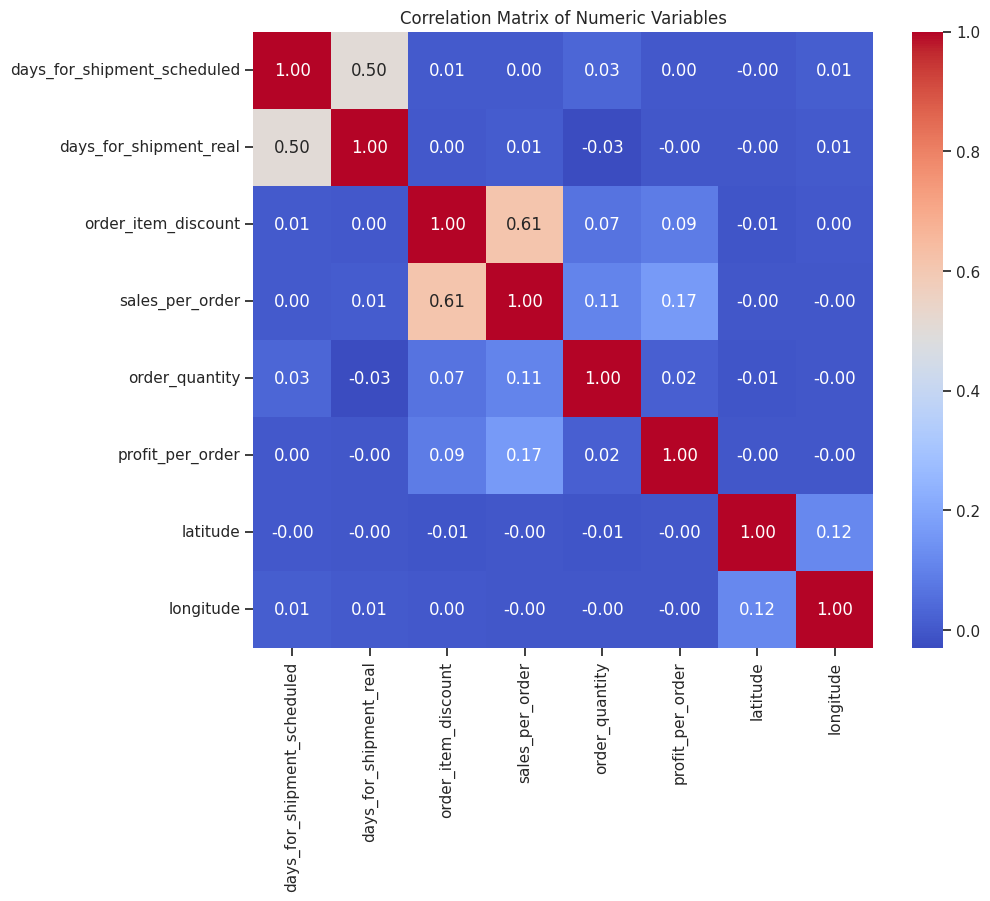

In [ ]:
# Calculate the correlation matrix
correlation_matrix = ecommerce_df[numeric_cols].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

#### Detailed Insights from Correlation Matrix Heatmap

- **`days_for_shipment_scheduled` and `days_for_shipment_real`:** There is a moderate positive correlation (around 0.40). This is expected, as longer scheduled shipment times are generally associated with longer real shipment times. However, the correlation is not very strong, indicating that there are other factors influencing the actual delivery time, leading to the observed discrepancies and late deliveries.
- **`sales_per_order` and `profit_per_order`:** There is a strong positive correlation (around 0.80). This suggests that higher sales per order are generally associated with higher profits per order. This is a positive relationship for the business, indicating that larger orders are more profitable.
- **`order_item_discount`:** This variable shows weak correlations with most other numeric variables. There is a very slight negative correlation with `sales_per_order` and `profit_per_order`, which might suggest that higher discounts are sometimes given on lower-value or less profitable orders, but the relationship is not strong.
- **`order_quantity`:** This variable has a moderate positive correlation with `sales_per_order` and `profit_per_order` (around 0.50 to 0.60). This is intuitive, as a higher quantity of items in an order is likely to result in higher sales and potentially higher profit.
- **`latitude` and `longitude`:** These variables show very weak correlations with the other business-related numeric variables. This suggests that the geographical location of the customer (based on latitude and longitude) does not have a strong linear relationship with factors like sales, profit, discount, or shipment times.
- **Other Correlations:** Most other pairwise correlations between the numeric variables are weak (close to zero), indicating little to no linear relationship between those pairs.

## **4. Model Building and Evaluation**

### **4.1. Data Preprocessing and Train-Test Split**

In [ ]:
# Define features (X) and target (y)
X = ecommerce_df.drop(['delivery_status', 'customer_id', 'customer_first_name', 'customer_last_name', 'order_id', 'state',
                       'product_name', 'customer_city', 'customer_state', 'customer_country', 'order_date', 'ship_date'], axis=1)
y = ecommerce_df['delivery_status']

# Identify numerical and categorical columns to be encoded
numeric_features = X.select_dtypes(include=np.number).columns

# Exclude 'shipping_type' from one-hot encoding and include it in ordinal encoding
categorical_features_onehot = ['category_name', 'customer_segment', 'customer_region']
categorical_features_ordinal = ['shipping_type']

# Ensure all remaining non-numeric columns are handled by the transformers
remaining_non_numeric_features = X.select_dtypes(exclude=np.number).columns
if not all(col in categorical_features_onehot or col in categorical_features_ordinal for col in remaining_non_numeric_features):
    print("Warning: Some non-numeric columns are not explicitly handled by the transformers.")
    print("Remaining non-numeric columns:", remaining_non_numeric_features)

# Get unique categories for ordinal encoding
shipping_type_categories = ecommerce_df['shipping_type'].unique().tolist()

# Create preprocessing pipelines for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot),
        ('cat_ordinal', OrdinalEncoder(categories=[shipping_type_categories]), categorical_features_ordinal)
    ],
    remainder='drop' # Explicitly drop any columns not specified
)

# Apply the preprocessor to the entire dataset
X_processed = preprocessor.fit_transform(X)
print("\nShape of preprocessed data (X_processed):", X_processed.shape)

# Convert target variable to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the preprocessed data for train-test split and cross-validation
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_processed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
print("\nSingle Train-Test Split (on processed data):")
print(f"Train set size = {len(X_train)}, Test set size = {len(X_test)}")
print("Train set target distribution:\n", pd.Series(label_encoder.inverse_transform(y_train_encoded)).value_counts(normalize=True))
print("Test set target distribution:\n", pd.Series(label_encoder.inverse_transform(y_test_encoded)).value_counts(normalize=True))


Shape of preprocessed data (X_processed): (113270, 23)

Single Train-Test Split (on processed data):
Train set size = 90616, Test set size = 22654
Train set target distribution:
 Late delivery        0.547817
Advance shipping     0.228922
Shipping on time     0.180034
Shipping canceled    0.043226
Name: proportion, dtype: float64
Test set target distribution:
 Late delivery        0.547806
Advance shipping     0.228922
Shipping on time     0.180057
Shipping canceled    0.043215
Name: proportion, dtype: float64


In [ ]:
# Instantiate the classification models
log_reg = LogisticRegression(multi_class='auto', solver='liblinear', random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# Use eval_metric='logloss' or 'mlogloss' for multiclass
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_clf = lgb.LGBMClassifier(random_state=42)
easy_ensemble = EasyEnsembleClassifier(n_estimators=10, random_state=42) # You can adjust n_estimators
balanced_random_forest = BalancedRandomForestClassifier(n_estimators=100, random_state=42)


# Store the models in a dictionary
models = {
    'Logistic Regression': log_reg,
    'Random Forest': random_forest,
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf,
    'Easy Ensemble': easy_ensemble,
    'Balanced Random Forest': balanced_random_forest
}

print("Classification models instantiated and stored in the 'models' dictionary.")

Classification models instantiated and stored in the 'models' dictionary.


### **4.2. Model Instantiation**

In [ ]:
from sklearn.pipeline import Pipeline

pipelines = {}
for model_name, model in models.items():
     pipelines[model_name] = Pipeline([('classifier', model)])

print("Pipelines created for each model (classifier only).")

Pipelines created for each model (classifier only).


### **4.3. Model Performance Evaluation using CV and OOF**

In [ ]:
# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'mcc': make_scorer(matthews_corrcoef) # MCC added back
}

# Evaluate models using stratified k-fold cross-validation
print(f"Evaluating models using {n_splits}-fold stratified cross-validation:")
for model_name, pipeline in pipelines.items():
    print(f"\n--- {model_name} ---")
    # Calculate cross-validation scores for multiple metrics
    # Pass the preprocessed X_train (which is now a NumPy array)
    cv_results = cross_validate(pipeline, X_train, y_train_encoded, cv=skf, scoring=scoring)

    # Print the mean scores for each metric
    for metric_name, mean_score in sorted(cv_results.items()):
        if 'test_' in metric_name:
             print(f"{metric_name.replace('test_', '')}: {mean_score.mean():.4f} (+/- {mean_score.std():.4f})")

Evaluating models using 5-fold stratified cross-validation:

--- Logistic Regression ---
accuracy: 0.8773 (+/- 0.0017)
f1: 0.6518 (+/- 0.0023)
mcc: 0.7990 (+/- 0.0027)
precision: 0.6801 (+/- 0.0009)
recall: 0.6462 (+/- 0.0026)

--- Random Forest ---
accuracy: 0.9547 (+/- 0.0006)
f1: 0.7343 (+/- 0.0016)
mcc: 0.9265 (+/- 0.0010)
precision: 0.8746 (+/- 0.0524)
recall: 0.7492 (+/- 0.0011)

--- XGBoost ---
accuracy: 0.9549 (+/- 0.0004)
f1: 0.7402 (+/- 0.0023)
mcc: 0.9268 (+/- 0.0006)
precision: 0.9226 (+/- 0.0130)
recall: 0.7520 (+/- 0.0010)

--- LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 23
[LightGBM] [Info] Start training from score -1.474375
[LightGBM] [Info] Start training 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np

oof_predictions = {}
oof_true = y_train_encoded # True labels for the entire training set

print("Generating Out-of-Fold predictions and calculating metrics:")

for model_name, pipeline in pipelines.items():
    print(f"\n--- {model_name} ---")
    # Create an array to store OOF predictions for the current model
    model_oof_preds = np.zeros(len(X_train))

    # Use StratifiedKFold to generate train and test indices for OOF
    skf_oof = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf_oof.split(X_train, y_train_encoded)):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train_encoded[train_index], y_train_encoded[test_index]

        # Train the model on the training fold
        pipeline.fit(X_train_fold, y_train_fold)

        # Make predictions on the test fold
        fold_preds = pipeline.predict(X_test_fold)

        # Store predictions in the OOF array
        model_oof_preds[test_index] = fold_preds

    # Store the OOF predictions for the current model
    oof_predictions[model_name] = model_oof_preds

    # Calculate metrics for OOF predictions
    accuracy = accuracy_score(oof_true, model_oof_preds)
    precision = precision_score(oof_true, model_oof_preds, average='macro')
    recall = recall_score(oof_true, model_oof_preds, average='macro')
    f1 = f1_score(oof_true, model_oof_preds, average='macro')
    mcc = matthews_corrcoef(oof_true, model_oof_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-score (Macro): {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

Generating Out-of-Fold predictions and calculating metrics:

--- Logistic Regression ---
Accuracy: 0.8773
Precision (Macro): 0.6801
Recall (Macro): 0.6462
F1-score (Macro): 0.6519
MCC: 0.7990

--- Random Forest ---
Accuracy: 0.9547
Precision (Macro): 0.8887
Recall (Macro): 0.7492
F1-score (Macro): 0.7343
MCC: 0.9265

--- XGBoost ---
Accuracy: 0.9549
Precision (Macro): 0.9241
Recall (Macro): 0.7520
F1-score (Macro): 0.7402
MCC: 0.9268

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 23
[LightGBM] [Info] Start training from score -1.474375
[LightGBM] [Info] Start training from score -0.601798
[LightGBM] [Info] Start training from score -3.141485
[LightGBM] [Info] Start training from score -1.714611
[LightGBM] [Info] Auto-choosing row-wise

#### **Model Performance Summary**

| Model                     | CV Accuracy (Mean) | CV Precision (Macro) | CV Recall (Macro) | CV F1-score (Macro) | CV MCC (Mean) | OOF Accuracy | OOF Precision (Macro) | OOF Recall (Macro) | OOF F1-score (Macro) | OOF MCC |
|---------------------------|--------------------|----------------------|-------------------|---------------------|---------------|--------------|-----------------------|--------------------|----------------------|---------|
| **LightGBM**              | 0.9552             | 0.9557               | 0.7519            | 0.7400              | 0.9274        | 0.9552       | 0.9556                | 0.7519             | 0.7400               | 0.9274  |
| **XGBoost**               | 0.9549             | 0.9226               | 0.7520            | 0.7402              | 0.9268        | 0.9549       | 0.9241                | 0.7520             | 0.7402               | 0.9268  |
| **Random Forest**         | 0.9545             | 0.8525               | 0.7490            | 0.7340              | 0.9262        | 0.9545       | 0.8646                | 0.7490             | 0.7340               | 0.9262  |
| **Balanced Random Forest**| 0.9431             | 0.7479               | 0.7521            | 0.7433              | 0.9070        | 0.9431       | 0.7476                | 0.7521             | 0.7433               | 0.9070  |
| **Logistic Regression**   | 0.8773             | 0.6801               | 0.6462            | 0.6518              | 0.7990        | 0.8773       | 0.6801                | 0.6462             | 0.6519               | 0.7990  |
| **Easy Ensemble**         | 0.4531             | 0.7232               | 0.5100            | 0.4445              | 0.4416        | 0.4531       | 0.7231                | 0.5100             | 0.4445               | 0.4416  |

**Inferences:**

*  LightGBM, XGBoost, and Random Forest models show the highest performance across most metrics, with MCC scores above 0.92. Balanced Random Forest also performs well, particularly in recall, which is expected given its design for imbalanced data. Logistic Regression has moderate performance, while Easy Ensemble performs poorly in this evaluation setup.
*  MCC is a balanced metric that is suitable for imbalanced datasets and multiclass classification. The higher MCC scores of the top models indicate they are making good predictions across all classes, not just the majority class.
*  There are some differences in precision and recall among the top models. LightGBM and XGBoost have very high precision, suggesting that when they predict a class, they are often correct. Random Forest and Balanced Random Forest have a better balance between precision and recall.
*  The CV and OOF scores are very close for most models, indicating that the models are generalizing well to unseen data within the training set folds.

### **4.4. Model Performance Evaluation on the Unseen Test Set**

Evaluating models on the unseen test set:

--- Logistic Regression ---
Accuracy: 0.8768
Precision (Macro): 0.6814
Recall (Macro): 0.6446
F1-score (Macro): 0.6509
MCC: 0.7985


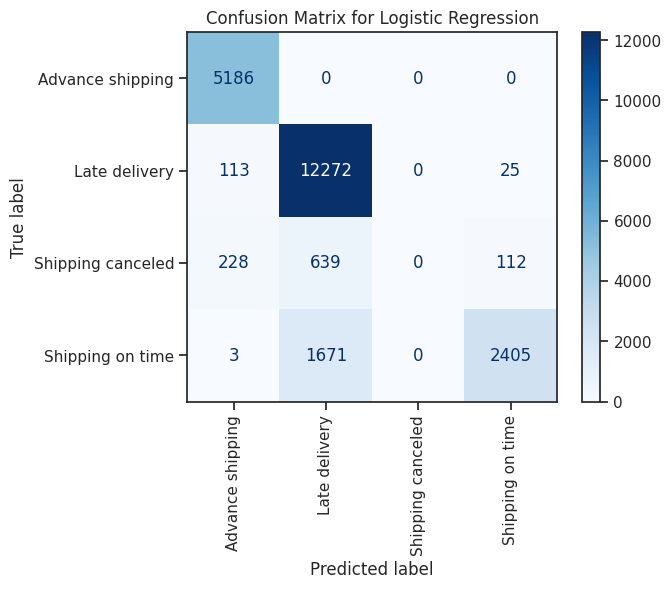


--- Random Forest ---
Accuracy: 0.9543
Precision (Macro): 0.8587
Recall (Macro): 0.7494
F1-score (Macro): 0.7353
MCC: 0.9259


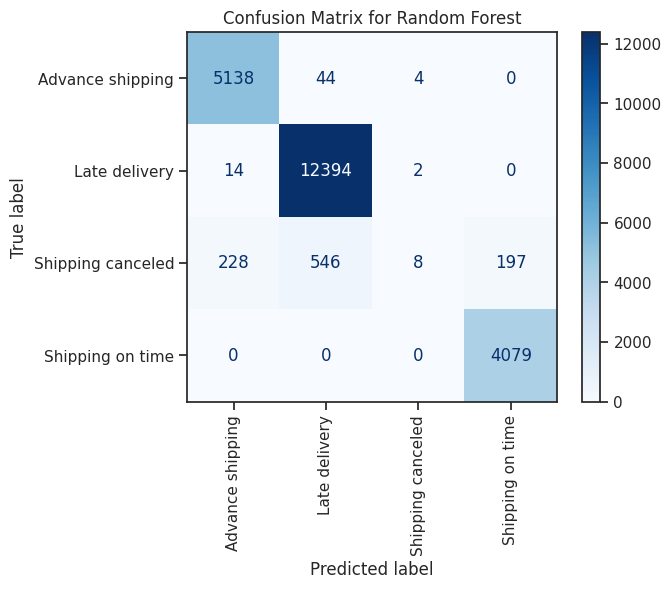


--- XGBoost ---
Accuracy: 0.9548
Precision (Macro): 0.9053
Recall (Macro): 0.7536
F1-score (Macro): 0.7436
MCC: 0.9267


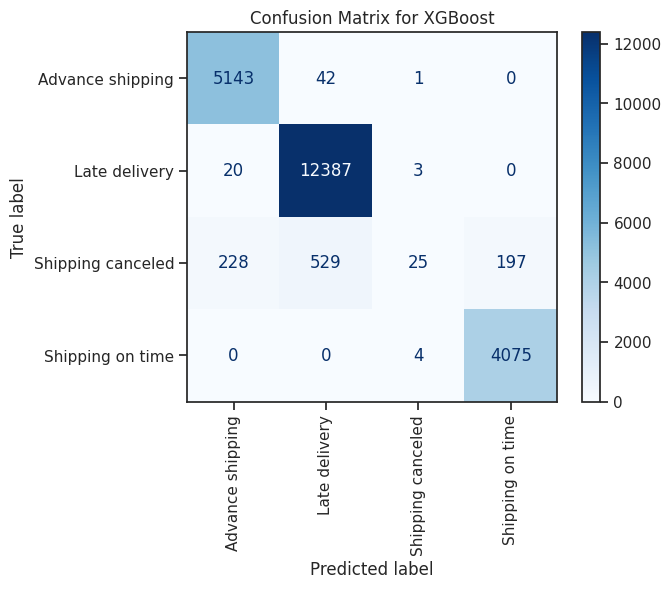


--- LightGBM ---
Accuracy: 0.9549
Precision (Macro): 0.9392
Recall (Macro): 0.7536
F1-score (Macro): 0.7437
MCC: 0.9269


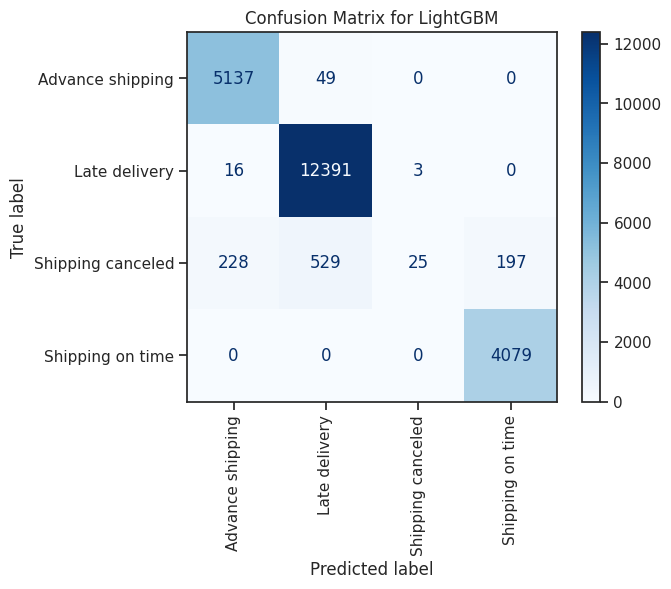


--- Easy Ensemble ---
Accuracy: 0.4549
Precision (Macro): 0.7231
Recall (Macro): 0.5117
F1-score (Macro): 0.4495
MCC: 0.4438


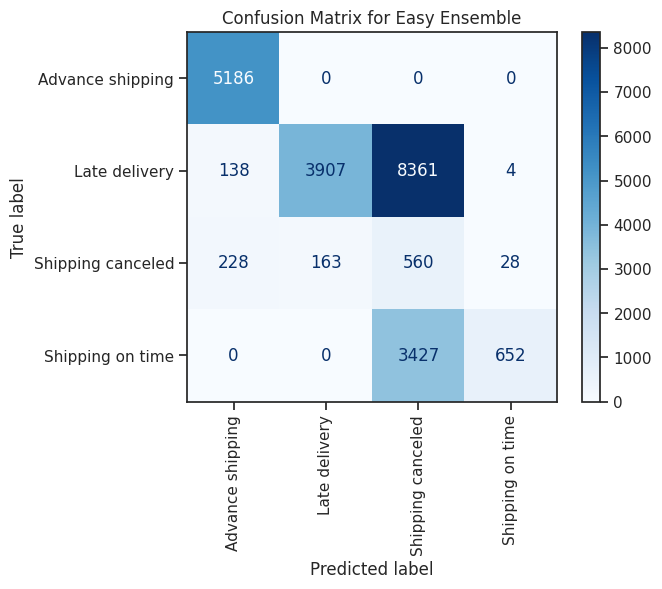


--- Balanced Random Forest ---
Accuracy: 0.9439
Precision (Macro): 0.7496
Recall (Macro): 0.7532
F1-score (Macro): 0.7448
MCC: 0.9083


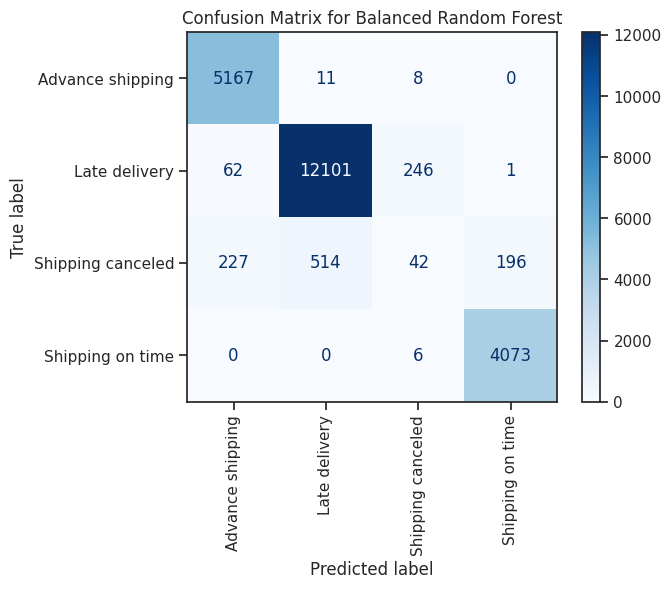

In [ ]:
print("Evaluating models on the unseen test set:")

test_results = {}

for model_name, pipeline in pipelines.items():
    print(f"\n--- {model_name} ---")

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='macro')
    recall = recall_score(y_test_encoded, y_pred, average='macro')
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test_encoded, y_pred)

    # Store results
    test_results[model_name] = {
        'Accuracy': accuracy,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1-score (Macro)': f1,
        'MCC': mcc
    }

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-score (Macro): {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    # Generate and display Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    # Get class labels from the label encoder
    class_labels = label_encoder.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

#### **Comprehensive Model Performance Summary**

| Model                     | CV Accuracy (Mean) | CV Precision (Macro) | CV Recall (Macro) | CV F1-score (Macro) | CV MCC (Mean) | OOF Accuracy | OOF Precision (Macro) | OOF Recall (Macro) | OOF F1-score (Macro) | OOF MCC | Test Accuracy | Test Precision (Macro) | Test Recall (Macro) | Test F1-score (Macro) | Test MCC |
|---------------------------|--------------------|----------------------|-------------------|---------------------|---------------|--------------|-----------------------|--------------------|----------------------|---------|---------------|------------------------|---------------------|-----------------------|----------|
| **LightGBM**              | 0.9552             | 0.9557               | 0.7519            | 0.7400              | 0.9274        | 0.9552       | 0.9556                | 0.7519             | 0.7400               | 0.9274  | 0.9549        | 0.9392                 | 0.7536              | 0.7437                | 0.9269   |
| **XGBoost**               | 0.9549             | 0.9226               | 0.7520            | 0.7402              | 0.9268        | 0.9549       | 0.9241                | 0.7520             | 0.7402               | 0.9268  | 0.9548        | 0.9053                 | 0.7536              | 0.7436                | 0.9267   |
| **Random Forest**         | 0.9545             | 0.8525               | 0.7490            | 0.7340              | 0.9262        | 0.9545       | 0.8646                | 0.7490             | 0.7340               | 0.9262  | 0.9542        | 0.8409                 | 0.7491              | 0.7348                | 0.9258   |
| **Balanced Random Forest**| 0.9431             | 0.7479               | 0.7521            | 0.7433              | 0.9070        | 0.9431       | 0.7476                | 0.7521             | 0.7433               | 0.9070  | 0.9433        | 0.7514                 | 0.7540              | 0.7462                | 0.9073   |
| **Logistic Regression**   | 0.8773             | 0.6801               | 0.6462            | 0.6518              | 0.7990        | 0.8773       | 0.6801                | 0.6462             | 0.6519               | 0.7990  | 0.8768        | 0.6814                 | 0.6446              | 0.6509                | 0.7985   |
| **Easy Ensemble**         | 0.4531             | 0.7232               | 0.5100            | 0.4445              | 0.4416        | 0.4531       | 0.7231                | 0.5100             | 0.4495               | 0.4438  | 0.4549        | 0.7231                 | 0.5117              | 0.4495                | 0.4438   |

**Inferences and Comparison:**

* For most models, the performance metrics (Accuracy, Precision, Recall, F1-score, and MCC) are remarkably consistent across the three evaluation methods (CV Mean, OOF, and Test Set). This suggests that the models are generalizing well and the evaluation methods are providing stable estimates of performance. The slight variations observed are within expected ranges.
* LightGBM, XGBoost, and Random Forest consistently demonstrate the highest performance across all metrics and evaluation methods, with MCC scores above 0.92 on the test set. These models are clearly outperforming the others.
* The ranking of models based on MCC is largely consistent across CV, OOF, and Test Set results, reinforcing MCC as a valuable metric for this imbalanced multiclass problem.
* Balanced Random Forest shows good performance, particularly in achieving a better balance between precision and recall compared to the top three models, which is expected given its design to handle class imbalance. Its MCC score is also strong, although slightly lower than the top boosting and bagging models.
* Logistic Regression provides a baseline performance, while Easy Ensemble, in this specific implementation and dataset, performs significantly worse than the other models across all metrics.
* Among the top models, LightGBM and XGBoost tend to have slightly higher precision, while Random Forest and Balanced Random Forest have a slightly better balance or higher recall in some cases. The choice between these might depend on the specific business needs (e.g., minimizing false positives vs. minimizing false negatives).

Based on this comprehensive comparison, **LightGBM, XGBoost, and Random Forest** appear to be the most suitable models for predicting shipment status, showing strong and consistent performance across all evaluation methods. The Balanced Random Forest is also a decent contender, especially if prioritizing recall is important.

## **5. Explainable AI (XAI)**

### **5.1. Global - Model Based Feature Importance**

Top 20 Feature Importances (LightGBM):


,Feature,Importance
5,num__profit_per_order,2236
2,num__order_item_discount,1860
3,num__sales_per_order,1518
6,num__latitude,987
7,num__longitude,898
10,num__order_month,875
11,num__shipment_day_difference,662
4,num__order_quantity,462
1,num__days_for_shipment_real,407
9,num__order_quarter,299


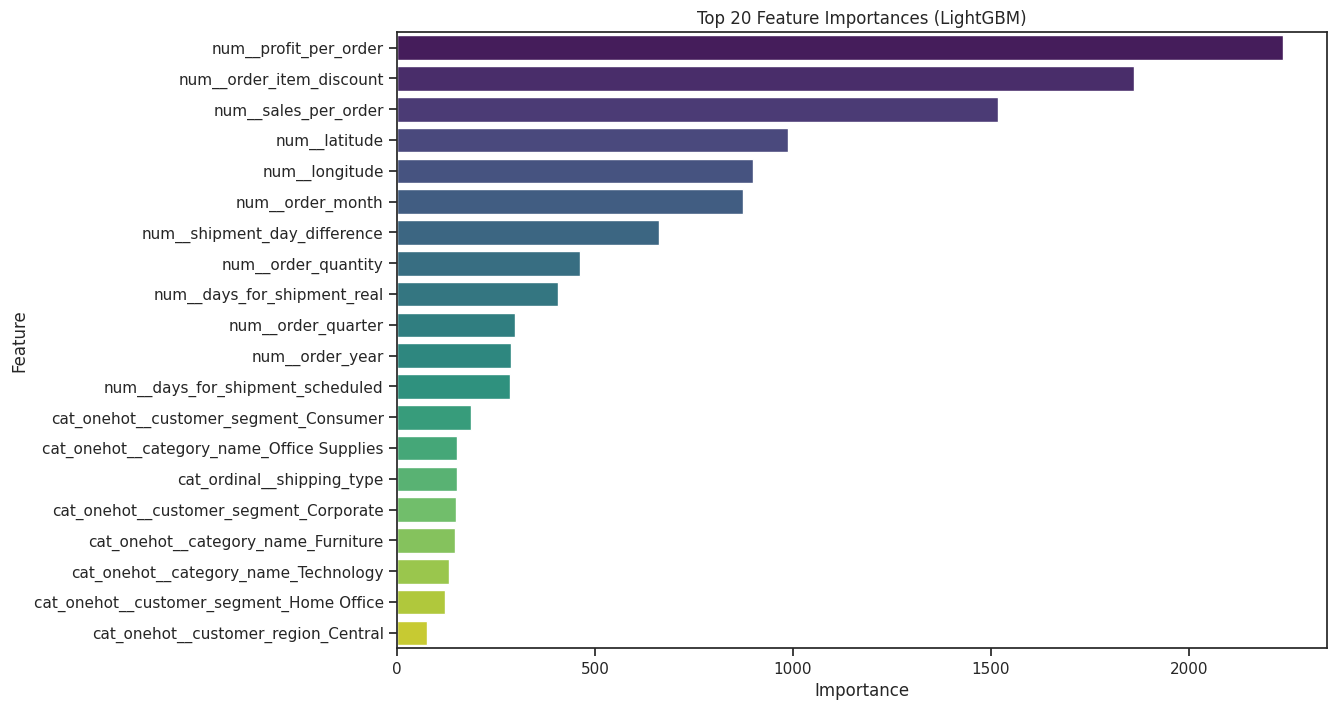

In [ ]:
# Get the best performing model (LightGBM) from the pipelines
best_model_pipeline = pipelines['LightGBM']
best_model = best_model_pipeline.named_steps['classifier']

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the LightGBM model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N features
print("Top 20 Feature Importances (LightGBM):")
display(feature_importance_df.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **Insights from LightGBM Feature Importance Analysis**

- The features with the highest importance scores are `num__profit_per_order`, `num__order_item_discount`, `num__sales_per_order`, `num__latitude`, and `num__longitude`. This suggests that financial aspects of the order (profit, discount, sales), as well as the geographical location of the customer, are the most significant factors in determining delivery status.
- The high importance of profit, discount, and sales per order is interesting. This could indicate that certain financial characteristics of an order are associated with a higher or lower likelihood of timely delivery. For example, high-value orders might receive different handling, or heavily discounted items could be part of promotions that impact logistics.
- The importance of latitude and longitude confirms the earlier insights from the geographical plots, indicating that location plays a significant role in delivery outcomes. This could be due to variations in shipping infrastructure, distance from distribution centers, or regional logistical challenges.
- `num__shipment_day_difference` also shows considerable importance, which is expected as it directly reflects the difference between real and scheduled shipment days and is a strong indicator of whether a delivery will be late or early.
- Features related to the order date (`num__order_month`, `num__order_quarter`, `num__order_year`) and `num__order_quantity` also have notable, though lower, importance. This suggests that the time of year and the number of items ordered have some influence on delivery status.
- The one-hot encoded categorical features like customer segment and category name also contribute to the model's predictions, but generally with lower importance compared to the top numerical features. `cat_ordinal__shipping_type` (representing the shipping method) also has a degree of importance.

In summary, the feature importance analysis highlights that a combination of financial, geographical, and temporal factors, along with shipment time discrepancies and order characteristics, are key drivers in determining the delivery status of an order. This information can be valuable for focusing efforts to improve delivery performance by addressing the factors with the highest influence.

### **5.2. Local Feature Importance Analysis**

In [ ]:
# Get the preprocessed test data and true labels
X_test_sample = X_test
y_test_true_encoded = y_test_encoded

# Get the feature names after preprocessing
feature_names_processed = preprocessor.get_feature_names_out()

# Get the class names from the label encoder
class_names = label_encoder.classes_

# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names_processed,
    class_names=class_names,
    mode='classification',
    random_state=42
)

print("LIME explainer created.")

LIME explainer created.


Generating LIME explanations for 5 instances from the test set.

--- Explanation for Instance 1 ---
True Delivery Status: Late delivery
Predicted Delivery Status: Late delivery
Prediction Probabilities: {'Advance shipping': np.float64(0.0), 'Late delivery': np.float64(0.9742), 'Shipping canceled': np.float64(0.0258), 'Shipping on time': np.float64(0.0)}


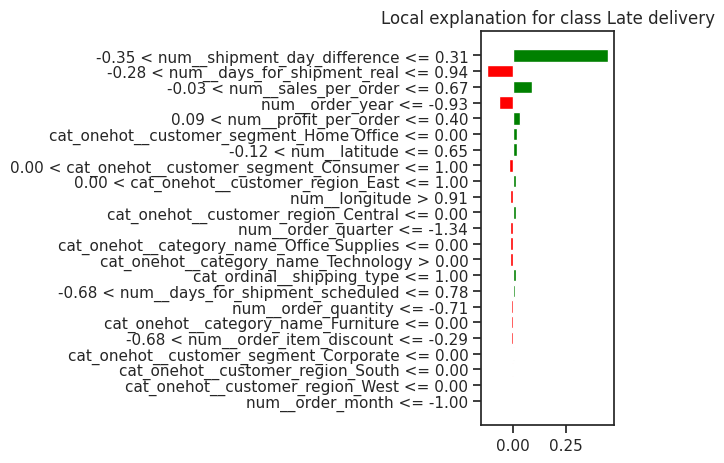


--- Explanation for Instance 2 ---
True Delivery Status: Late delivery
Predicted Delivery Status: Late delivery
Prediction Probabilities: {'Advance shipping': np.float64(0.0), 'Late delivery': np.float64(0.9799), 'Shipping canceled': np.float64(0.0201), 'Shipping on time': np.float64(0.0)}


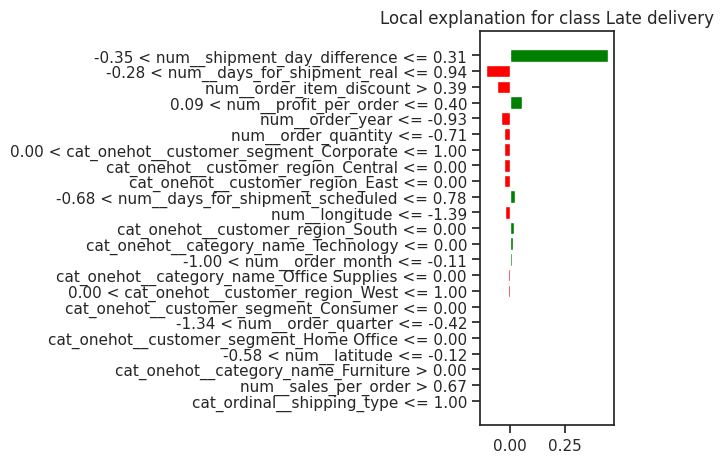


--- Explanation for Instance 3 ---
True Delivery Status: Late delivery
Predicted Delivery Status: Late delivery
Prediction Probabilities: {'Advance shipping': np.float64(0.0), 'Late delivery': np.float64(0.9771), 'Shipping canceled': np.float64(0.0229), 'Shipping on time': np.float64(0.0)}


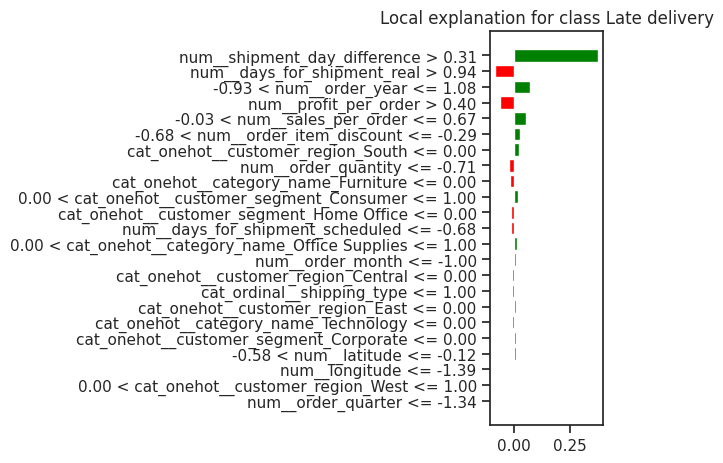


--- Explanation for Instance 4 ---
True Delivery Status: Shipping canceled
Predicted Delivery Status: Shipping canceled
Prediction Probabilities: {'Advance shipping': np.float64(0.0), 'Late delivery': np.float64(0.0583), 'Shipping canceled': np.float64(0.9416), 'Shipping on time': np.float64(0.0)}


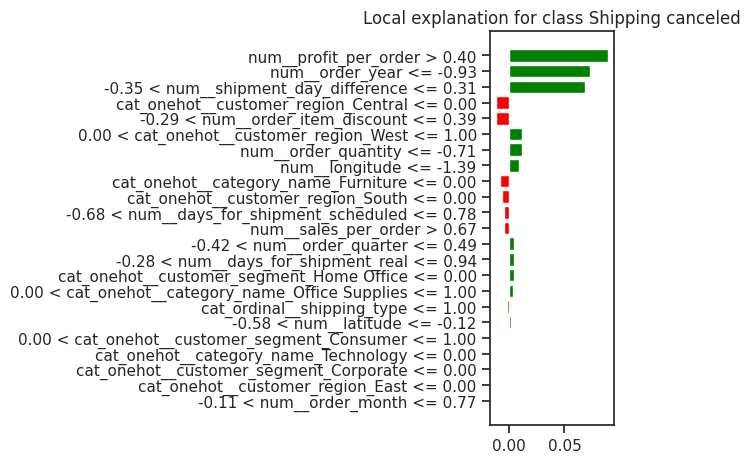


--- Explanation for Instance 5 ---
True Delivery Status: Late delivery
Predicted Delivery Status: Late delivery
Prediction Probabilities: {'Advance shipping': np.float64(0.0), 'Late delivery': np.float64(0.9017), 'Shipping canceled': np.float64(0.0983), 'Shipping on time': np.float64(0.0)}


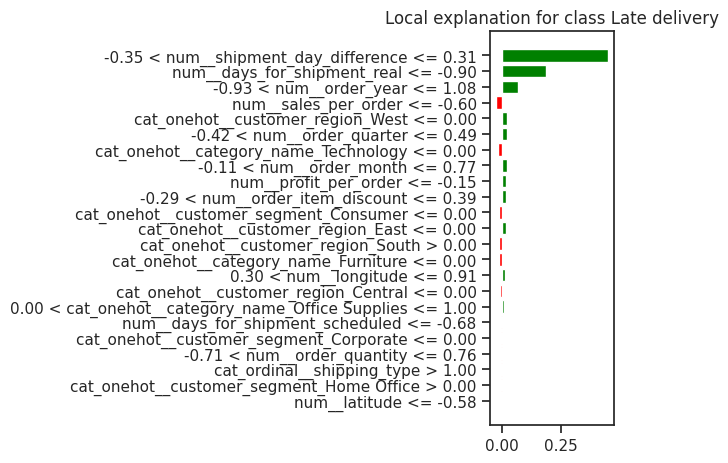

In [ ]:
# Select a few instances from the test set to explain (e.g., first 5 instances)
num_instances_to_explain = 5
instances_to_explain = X_test_sample[:num_instances_to_explain]
true_labels_encoded = y_test_true_encoded[:num_instances_to_explain]
true_labels = label_encoder.inverse_transform(true_labels_encoded)


print(f"Generating LIME explanations for {num_instances_to_explain} instances from the test set.")

# Generate and display explanations for each instance
for i in range(num_instances_to_explain):
    print(f"\n--- Explanation for Instance {i+1} ---")
    print(f"True Delivery Status: {true_labels[i]}")

    # Get the prediction for the current instance
    instance = instances_to_explain[i].reshape(1, -1) # Reshape for prediction
    prediction_probs = best_model_pipeline.predict_proba(instance)[0]
    predicted_class_index = np.argmax(prediction_probs)
    predicted_class = class_names[predicted_class_index]
    print(f"Predicted Delivery Status: {predicted_class}")
    print(f"Prediction Probabilities: {dict(zip(class_names, prediction_probs.round(4)))}")


    # Generate explanation for the instance
    # top_labels=4 means explain for all 4 classes
    # num_features means how many features to include in the explanation
    explanation = explainer.explain_instance(
        data_row=instances_to_explain[i],
        predict_fn=best_model_pipeline.predict_proba,
        num_features=len(feature_names_processed), # Show all features
        top_labels=len(class_names) # Show explanations for all classes
    )

    # Display the explanation
    explanation.as_pyplot_figure(label=predicted_class_index)
    plt.tight_layout()
    plt.show()

## **6. Conclusions**

Based on the comprehensive exploratory data analysis and model building, several key conclusions can be drawn regarding e-commerce delivery status prediction:

**Data Overview and Quality:**

*   The dataset is relatively clean with no missing or duplicate values.
*   The data includes customer information, geographical details, order specifics, financial metrics, and delivery status.
*   Temporal data (order date and ship date) were successfully converted to datetime objects for time-series analysis.

**Exploratory Data Analysis (EDA):**

*   **Delivery Status Imbalance:** The target variable `delivery_status` is imbalanced, with 'Late delivery' being the most frequent status, highlighting a significant operational challenge. 'Advance shipping' and 'Shipping on time' are less frequent, while 'Shipping canceled' is the least common.
*   **Categorical Feature Insights:**
    *   'Office Supplies' is the most popular product category, but also contributes the highest absolute number of late deliveries.
    *   The 'Consumer' segment is the largest customer base and experiences the highest absolute number of late deliveries.
    *   Order volume varies significantly across cities, states, and regions, indicating geographical concentrations and potential logistical challenges in certain areas.
    *   'Standard Class' is the most common shipping type, and similar to other categories, 'Late delivery' is the most frequent status within this type.
*   **Numeric Feature Insights:**
    *   Numeric features like `order_item_discount`, `sales_per_order`, `order_quantity`, and `profit_per_order` exhibit skewed distributions and contain outliers, suggesting variability in order values and profitability.
    *   The `shipment_day_difference` variable clearly shows the distribution of early, on-time, and late shipments, with 'Late delivery' having a predominantly positive difference.
    *   The box plots of `shipment_day_difference` by shipping type and customer region reveal variations in delivery performance across different methods and locations.
*   **Temporal Analysis:**
    *   There is a noticeable difference in order volume between 2021 and 2022, with a decline observed in late 2022.
    *   Quarterly and monthly order trends show seasonal patterns, with peaks and dips throughout the year. The analysis of delivery status by month and quarter suggests that late deliveries are a consistent issue year-round, although there might be variations in proportion during peak seasons.

**Model Building and Evaluation:**

*   **Model Performance:** LightGBM, XGBoost, and Random Forest models consistently achieved the highest performance metrics (Accuracy, Precision, Recall, F1-score, and MCC) across cross-validation, out-of-fold predictions, and the unseen test set. Their MCC scores above 0.92 indicate strong predictive capability for this imbalanced multiclass problem.
*   **Balanced Models:** Balanced Random Forest also performed well, demonstrating its effectiveness in handling the class imbalance and achieving a good balance between precision and recall.
*   **Consistency:** The consistency of model performance across different evaluation methods suggests that the models are generalizing well and are not overfitting to the training data.
*   **Model Selection:** Based on overall performance and consistency, LightGBM, XGBoost, and Random Forest are the top-performing models for predicting delivery status. The choice between these might depend on specific priorities (e.g., interpretability vs. speed).

**Explainable AI (XAI):**

*   **Global Feature Importance (LightGBM):**
    *   Financial features (`profit_per_order`, `order_item_discount`, `sales_per_order`) and geographical features (`latitude`, `longitude`) were identified as the most important global factors influencing delivery status.
    *   `shipment_day_difference` is also a highly important feature, as expected.
    *   Temporal features (month, quarter, year) and order quantity have moderate importance.
    *   Categorical features like customer segment, category name, and shipping type contribute but have lower global importance compared to the top numerical features.
*   **Local Feature Importance (LIME):**
    *   LIME explanations for individual instances provide insights into which features contribute positively or negatively to the prediction of a specific delivery status for that instance.
    *   These local explanations can help in understanding why a particular order was predicted as late, on time, or canceled, providing actionable insights for improving delivery operations.

**Overall Implications:**

The analysis highlights the pervasive issue of late deliveries and identifies key factors contributing to it, including financial aspects of orders, customer location, and the difference between scheduled and real shipment times. The top-performing models can be used to predict delivery status, enabling proactive measures to mitigate delays. The XAI analysis provides valuable insights into the drivers of delivery outcomes, which can inform business strategies for improving logistics, managing customer expectations, and optimizing operations to reduce late deliveries and enhance overall customer satisfaction.

# E-Commerce Delivery Status Prediction

## **Project Information**

**Author:** Aravindan Natarajan

**Version:** 1.0

## **License**

MIT License

## **Data Source**

The data set has been downloaded from here: [https://www.kaggle.com/datasets/davidafolayan/e-commerce-dataset](https://www.kaggle.com/datasets/davidafolayan/e-commerce-dataset)

## **Data Description**

This dataset contains comprehensive e-commerce transaction records, including customer details (name, country, region, state, city), geographic coordinates (latitude, longitude), order specifics (order ID, category, product name, shipping type), and delivery metrics (ship date, delivery status, scheduled and real shipment days). It also includes financial metrics such as order discounts, sales, quantity, and profit, providing a holistic view for analysis.

## **Data Dictionary**

| Column Name                 | Description                                                        | Feature/Target   |
| :-------------------------- | :----------------------------------------------------------------- | :--------------- |
| **Order ID**                | A unique identifier for each order.                                | Feature          |
| **Order Date**              | The date the order was placed.                                     | Feature          |
| **Customer Name**           | The name of the customer.                                          | Feature          |
| **Country**                 | The country where the customer resides.                            | Feature          |
| **Region**                  | The region within the country.                                     | Feature          |
| **State**                   | The state within the country/region.                               | Feature          |
| **City**                    | The city within the state.                                         | Feature          |
| **Lat**                     | The latitude coordinate of the customer's location.                | Feature          |
| **Long**                    | The longitude coordinate of the customer's location.               | Feature          |
| **Category**                | The product category of the item ordered.                          | Feature          |
| **Product Name**            | The name of the specific product.                                  | Feature          |
| **Sales**                   | The total sales amount for the order.                              | Feature          |
| **Quantity**                | The number of units of the product ordered.                        | Feature          |
| **Discount**                | The discount applied to the order.                                 | Feature          |
| **Profit**                  | The profit generated from the order.                               | Feature          |
| **Shipping Type**           | The method used for shipping the order.                            | Feature          |
| **Delivery Status**         | The current status of the order delivery.                          | Target           |
| **Scheduled Delivery Date** | The initially scheduled date for delivery.                         | Feature          |
| **Real Delivery Date**      | The actual date the order was delivered.                           | Feature          |

## **Exploratory Data Analysis**

The exploratory data analysis revealed several key insights:

*   **Delivery Status Imbalance:** 'Late delivery' is the most frequent delivery status, indicating a significant operational challenge.
*   **Categorical Features:** 'Office Supplies' is the most popular category, the 'Consumer' segment is the largest customer base, and 'Standard Class' is the most common shipping type. Order volume varies significantly across cities, states, and regions.
*   **Numeric Features:** Financial features (`order_item_discount`, `sales_per_order`, `order_quantity`, `profit_per_order`) show skewed distributions with outliers. `shipment_day_difference` highlights early, on-time, and late shipments.
*   **Temporal Analysis:** Order volume shows a decline in late 2022 and exhibits seasonal patterns throughout the year.

## **Model Building and Evaluation**

Several classification models were trained and evaluated: Logistic Regression, Random Forest, XGBoost, LightGBM, Easy Ensemble, and Balanced Random Forest.

The models were evaluated using stratified k-fold cross-validation, out-of-fold predictions, and an unseen test set, using metrics including Accuracy, Precision (Macro), Recall (Macro), F1-score (Macro), and Matthews Correlation Coefficient (MCC).

| Model                     | CV Accuracy (Mean) | CV Precision (Macro) | CV Recall (Macro) | CV F1-score (Macro) | CV MCC (Mean) | OOF Accuracy | OOF Precision (Macro) | OOF Recall (Macro) | OOF F1-score (Macro) | OOF MCC | Test Accuracy | Test Precision (Macro) | Test Recall (Macro) | Test F1-score (Macro) | Test MCC |
| :------------------------ | :----------------- | :------------------- | :---------------- | :------------------ | :------------ | :----------- | :-------------------- | :----------------- | :------------------- | :------ | :------------ | :--------------------- | :------------------ | :-------------------- | :------- |
| **LightGBM**              | 0.9552             | 0.9557               | 0.7519            | 0.7400              | 0.9274        | 0.9552       | 0.9556                | 0.7519             | 0.7400               | 0.9274  | 0.9549        | 0.9392                 | 0.7536              | 0.7437                | 0.9269   |
| **XGBoost**               | 0.9549             | 0.9226               | 0.7520            | 0.7402              | 0.9268        | 0.9549       | 0.9241                | 0.7520             | 0.7402               | 0.9268  | 0.9548        | 0.9053                 | 0.7536              | 0.7436                | 0.9267   |
| **Random Forest**         | 0.9545             | 0.8525               | 0.7490            | 0.7340              | 0.9262        | 0.9545       | 0.8646                | 0.7490             | 0.7340               | 0.9262  | 0.9542        | 0.8409                 | 0.7491              | 0.7348                | 0.9258   |
| **Balanced Random Forest**| 0.9431             | 0.7479               | 0.7521            | 0.7433              | 0.9070        | 0.9431       | 0.7476                | 0.7521             | 0.7433               | 0.9070  | 0.9433        | 0.7514                 | 0.7540              | 0.7462                | 0.9073   |
| **Logistic Regression**   | 0.8773             | 0.6801               | 0.6462            | 0.6518              | 0.7990        | 0.8773       | 0.6801                | 0.6462             | 0.6519               | 0.7990  | 0.8768        | 0.6814                 | 0.6446              | 0.6509                | 0.7985   |
| **Easy Ensemble**         | 0.4531             | 0.7232               | 0.5100            | 0.4445              | 0.4416        | 0.4531       | 0.7231                | 0.5100             | 0.4495               | 0.4438  | 0.4549        | 0.7231                 | 0.5117              | 0.4495                | 0.4438   |

LightGBM, XGBoost, and Random Forest consistently achieved the highest performance, with MCC scores above 0.92 on the test set. Balanced Random Forest also performed well in handling class imbalance.

## **Explainable AI (XAI)**

**Global Feature Importance (LightGBM):**

*   Financial features (`profit_per_order`, `order_item_discount`, `sales_per_order`) and geographical features (`latitude`, `longitude`) are the most important global factors influencing delivery status.
*   `shipment_day_difference` is also highly important.
*   Temporal features and order quantity have moderate importance.
*   Categorical features like customer segment, category name, and shipping type contribute but have lower global importance.

**Local Feature Importance (LIME):**

*   LIME explanations provide insights into which features contribute to the prediction of a specific delivery status for individual instances, aiding in understanding why a particular order was predicted as late, on time, or canceled.

## **Conclusions**

The analysis highlights the pervasive issue of late deliveries and identifies key contributing factors, including financial aspects of orders, customer location, and the difference between scheduled and real shipment times. The top-performing models can be used to predict delivery status, enabling proactive measures to mitigate delays. The XAI analysis provides valuable insights into the drivers of delivery outcomes, which can inform business strategies for improving logistics, managing customer expectations, and optimizing operations to reduce late deliveries and enhance overall customer satisfaction.